In [ ]:
!pip install -q protobuf==3.20.3

In [3]:
!pip install -q monai[all] nibabel scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 22.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 9.3 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 4.2 MB/s eta 0:00:0000:0100:01mm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 16.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 4.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 4.2 MB/s eta 0:

In [ ]:
# Test cell - run this to confirm everything is installed
import torch
import monai
import nibabel as nib
import numpy as np

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ MONAI: {monai.__version__}")
print(f"✅ NiBabel: {nib.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
print(f"✅ GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

In [4]:

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from pathlib import Path
import random
from tqdm import tqdm
import gc

In [5]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    NormalizeIntensityd, RandSpatialCropd, RandFlipd, 
    RandRotate90d, RandGaussianNoised, ToTensord, SpatialPadd,
    RandScaleIntensityd, RandShiftIntensityd, Lambda, Lambdad
)

In [6]:
CONFIG = {
    'data_path': '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData',
    'num_train_samples': 50,
    'num_val_samples': 10,
    'batch_size': 2,  # Increased to 2 for faster training
    'patch_size': (64, 64, 64),
    'num_epochs': 15,
    'val_interval': 3,
    'num_workers': 0,
}

In [7]:
def convert_labels_to_binary(label):
    """Convert BRATS labels to 3-channel binary format
    Input: (C, H, W, D) with values {0, 1, 2, 4}
    Output: (3, H, W, D) with binary masks for each class
    """
    result = torch.zeros((3,) + label.shape[1:], dtype=torch.float32)
    # Channel 0: Necrotic tumor (label 1)
    result[0] = (label[0] == 1).float()
    # Channel 1: Edema (label 2)
    result[1] = (label[0] == 2).float()
    # Channel 2: Enhancing tumor (label 4)
    result[2] = (label[0] == 4).float()
    return result

In [8]:
def get_data_dicts(data_path, num_samples=None):
    """Get data dictionaries"""
    data_dir = Path(data_path)
    subjects = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    
    if num_samples:
        subjects = subjects[:num_samples]
    
    data_dicts = []
    for subj in subjects:
        data_dict = {
            'image': [
                str(subj / f'{subj.name}_flair.nii'),
                str(subj / f'{subj.name}_t1.nii'),
                str(subj / f'{subj.name}_t1ce.nii'),
                str(subj / f'{subj.name}_t2.nii'),
            ],
            'label': str(subj / f'{subj.name}_seg.nii'),
        }
        if all(os.path.exists(f) for f in data_dict['image']) and os.path.exists(data_dict['label']):
            data_dicts.append(data_dict)
    
    return data_dicts

In [9]:
def get_transforms(mode='train'):
    """Transforms with proper label conversion"""
    if mode == 'train':
        return Compose([
            LoadImaged(keys=['image', 'label']),
            EnsureChannelFirstd(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(2.0, 2.0, 2.0), mode=('bilinear', 'nearest')),
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            SpatialPadd(keys=['image', 'label'], spatial_size=CONFIG['patch_size'], mode='constant'),
            NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
            # Simple spatial crop instead of pos/neg sampling
            RandSpatialCropd(keys=['image', 'label'], roi_size=CONFIG['patch_size'], random_size=False),
            # Convert labels to binary format
            Lambdad(keys='label', func=convert_labels_to_binary),
            # Augmentations
            RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
            RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=3),
            RandGaussianNoised(keys='image', prob=0.3, mean=0.0, std=0.05),
            RandScaleIntensityd(keys='image', factors=0.1, prob=0.3),
            RandShiftIntensityd(keys='image', offsets=0.1, prob=0.3),
            ToTensord(keys=['image', 'label']),
        ])
    else:
        return Compose([
            LoadImaged(keys=['image', 'label']),
            EnsureChannelFirstd(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(2.0, 2.0, 2.0), mode=('bilinear', 'nearest')),
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            SpatialPadd(keys=['image', 'label'], spatial_size=CONFIG['patch_size'], mode='constant'),
            NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
            RandSpatialCropd(keys=['image', 'label'], roi_size=CONFIG['patch_size'], random_size=False),
            Lambdad(keys='label', func=convert_labels_to_binary),
            ToTensord(keys=['image', 'label']),
        ])

# ============================================================
# PREPARE DATA
# ============================================================
print("🔍 Loading dataset metadata...")
all_data = get_data_dicts(CONFIG['data_path'])
print(f"Found {len(all_data)} subjects")

random.seed(42)
random.shuffle(all_data)
train_data = all_data[:CONFIG['num_train_samples']]
val_data = all_data[CONFIG['num_train_samples']:CONFIG['num_train_samples']+CONFIG['num_val_samples']]

print(f"📊 Using {len(train_data)} training, {len(val_data)} validation subjects")


🔍 Loading dataset metadata...
Found 368 subjects
📊 Using 50 training, 10 validation subjects


In [11]:
from monai.data import CacheDataset, DataLoader as MonaiDataLoader

train_ds = CacheDataset(
    data=train_data,
    transform=get_transforms('train'),
    cache_rate=0.0,
    num_workers=CONFIG['num_workers']
)

val_ds = CacheDataset(
    data=val_data,
    transform=get_transforms('val'),
    cache_rate=0.0,
    num_workers=CONFIG['num_workers']
)

train_loader = MonaiDataLoader(
    train_ds,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader = MonaiDataLoader(
    val_ds,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print(f"✅ Created dataloaders: {len(train_loader)} train batches, {len(val_loader)} val batches")


✅ Created dataloaders: 25 train batches, 5 val batches


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Using device: {device}")

model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Use BCE+Dice loss for better stability with binary targets
loss_function = DiceLoss(sigmoid=True, squared_pred=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['num_epochs'])

dice_metric = DiceMetric(include_background=False, reduction='mean', get_not_nans=False)

print(f"✅ Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")


💻 Using device: cuda
✅ Model initialized with 4,810,074 parameters


In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_losses = []
val_metrics = []

print("\n🚀 Starting training...\n")

for epoch in range(CONFIG['num_epochs']):
    model.train()
    epoch_loss = 0
    step = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    for batch_data in pbar:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        del inputs, labels, outputs, loss
        
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    scheduler.step()
    
    print(f"Epoch {epoch+1} avg loss: {epoch_loss:.4f}")
    
    # Validation
    if (epoch + 1) % CONFIG['val_interval'] == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_step = 0
            
            for val_data in val_loader:
                val_step += 1
                val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels).item()
                
                # Compute Dice
                val_outputs_binary = (torch.sigmoid(val_outputs) > 0.5).float()
                dice_metric(y_pred=val_outputs_binary, y=val_labels)
                
                del val_inputs, val_labels, val_outputs, val_outputs_binary
            
            val_loss /= val_step
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            
            val_metrics.append(metric)
            
            print(f"✓ Validation - Loss: {val_loss:.4f}, Dice: {metric:.4f}")
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"🎯 New best model saved! Dice: {best_metric:.4f}")
    
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n✅ Training complete! Best Dice: {best_metric:.4f} at epoch {best_metric_epoch}")



🚀 Starting training...



Epoch 1/15: 100%|██████████| 25/25 [01:41<00:00,  4.08s/it, loss=0.9156]


Epoch 1 avg loss: 0.9460


Epoch 2/15: 100%|██████████| 25/25 [00:39<00:00,  1.56s/it, loss=0.8983]


Epoch 2 avg loss: 0.9242


Epoch 3/15: 100%|██████████| 25/25 [00:38<00:00,  1.56s/it, loss=0.8917]


Epoch 3 avg loss: 0.9071
✓ Validation - Loss: 0.9211, Dice: 0.2605
🎯 New best model saved! Dice: 0.2605


Epoch 4/15: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it, loss=0.9258]


Epoch 4 avg loss: 0.9058


Epoch 5/15: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it, loss=0.9655]


Epoch 5 avg loss: 0.8884


Epoch 6/15: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it, loss=0.9505]


Epoch 6 avg loss: 0.8376
✓ Validation - Loss: 0.8543, Dice: 0.3438
🎯 New best model saved! Dice: 0.3438


Epoch 7/15: 100%|██████████| 25/25 [00:37<00:00,  1.50s/it, loss=0.9489]


Epoch 7 avg loss: 0.8544


Epoch 8/15: 100%|██████████| 25/25 [00:38<00:00,  1.52s/it, loss=0.8807]


Epoch 8 avg loss: 0.8229


Epoch 9/15: 100%|██████████| 25/25 [00:38<00:00,  1.52s/it, loss=0.7268]


Epoch 9 avg loss: 0.7802
✓ Validation - Loss: 0.7536, Dice: 0.5199
🎯 New best model saved! Dice: 0.5199


Epoch 10/15: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it, loss=0.8837]


Epoch 10 avg loss: 0.7500


Epoch 11/15: 100%|██████████| 25/25 [00:38<00:00,  1.54s/it, loss=0.6830]


Epoch 11 avg loss: 0.7506


Epoch 12/15: 100%|██████████| 25/25 [00:38<00:00,  1.54s/it, loss=0.8233]


Epoch 12 avg loss: 0.7380
✓ Validation - Loss: 0.7373, Dice: 0.4269


Epoch 13/15: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it, loss=0.7623]


Epoch 13 avg loss: 0.7319


Epoch 14/15: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it, loss=0.7501]


Epoch 14 avg loss: 0.7550


Epoch 15/15: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it, loss=0.7281]


Epoch 15 avg loss: 0.7283
✓ Validation - Loss: 0.7671, Dice: 0.4063

✅ Training complete! Best Dice: 0.5199 at epoch 9


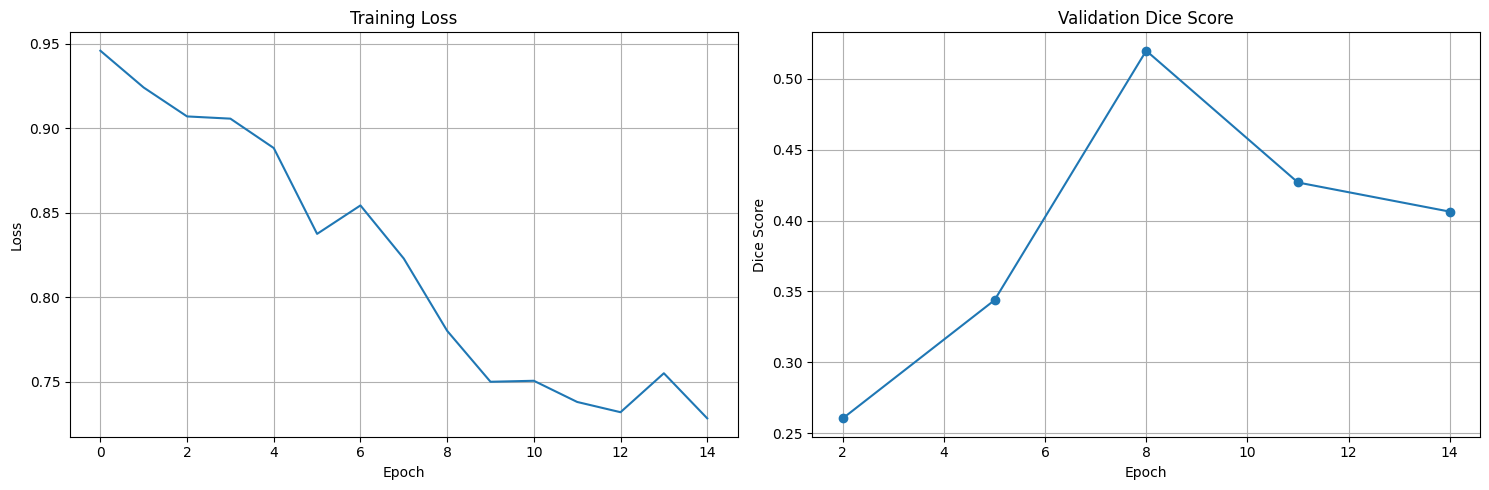


📈 Training curves saved!
💾 Best model: 'best_model.pth' (Dice: 0.5199)


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epoch_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

val_epochs = list(range(CONFIG['val_interval']-1, CONFIG['num_epochs'], CONFIG['val_interval']))
ax2.plot(val_epochs, val_metrics, marker='o')
ax2.set_title('Validation Dice Score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Dice Score')
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n📈 Training curves saved!")
print(f"💾 Best model: 'best_model.pth' (Dice: {best_metric:.4f})")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import nibabel as nib
from pathlib import Path
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, 
    Orientationd, NormalizeIntensityd, ToTensord
)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from monai.networks.nets import UNet
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [17]:
data_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
data_dir = Path(data_path)
subjects = sorted([d for d in data_dir.iterdir() if d.is_dir()])

# Use a validation subject for visualization
test_subject = subjects[55]  # Pick one not in training
print(f"📊 Testing on: {test_subject.name}")

test_data = {
    'image': [
        str(test_subject / f'{test_subject.name}_flair.nii'),
        str(test_subject / f'{test_subject.name}_t1.nii'),
        str(test_subject / f'{test_subject.name}_t1ce.nii'),
        str(test_subject / f'{test_subject.name}_t2.nii'),
    ],
    'label': str(test_subject / f'{test_subject.name}_seg.nii'),
}

📊 Testing on: BraTS20_Training_056


In [18]:
inference_transform = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(2.0, 2.0, 2.0), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ToTensord(keys=['image', 'label']),
])

test_data = inference_transform(test_data)
test_image = test_data['image'].unsqueeze(0).to(device)
test_label = test_data['label'].cpu().numpy()[0]

print(f"✅ Test image shape: {test_image.shape}")

✅ Test image shape: torch.Size([1, 4, 120, 120, 78])


In [19]:
print("🔍 Running inference...")
with torch.no_grad():
    test_output = sliding_window_inference(
        test_image, 
        roi_size=(64, 64, 64),
        sw_batch_size=4,
        predictor=model,
        overlap=0.5
    )

# Convert to binary predictions
prediction = torch.sigmoid(test_output[0]).cpu().numpy()
prediction_binary = (prediction > 0.5).astype(np.uint8)

print("✅ Inference complete!")

🔍 Running inference...
✅ Inference complete!


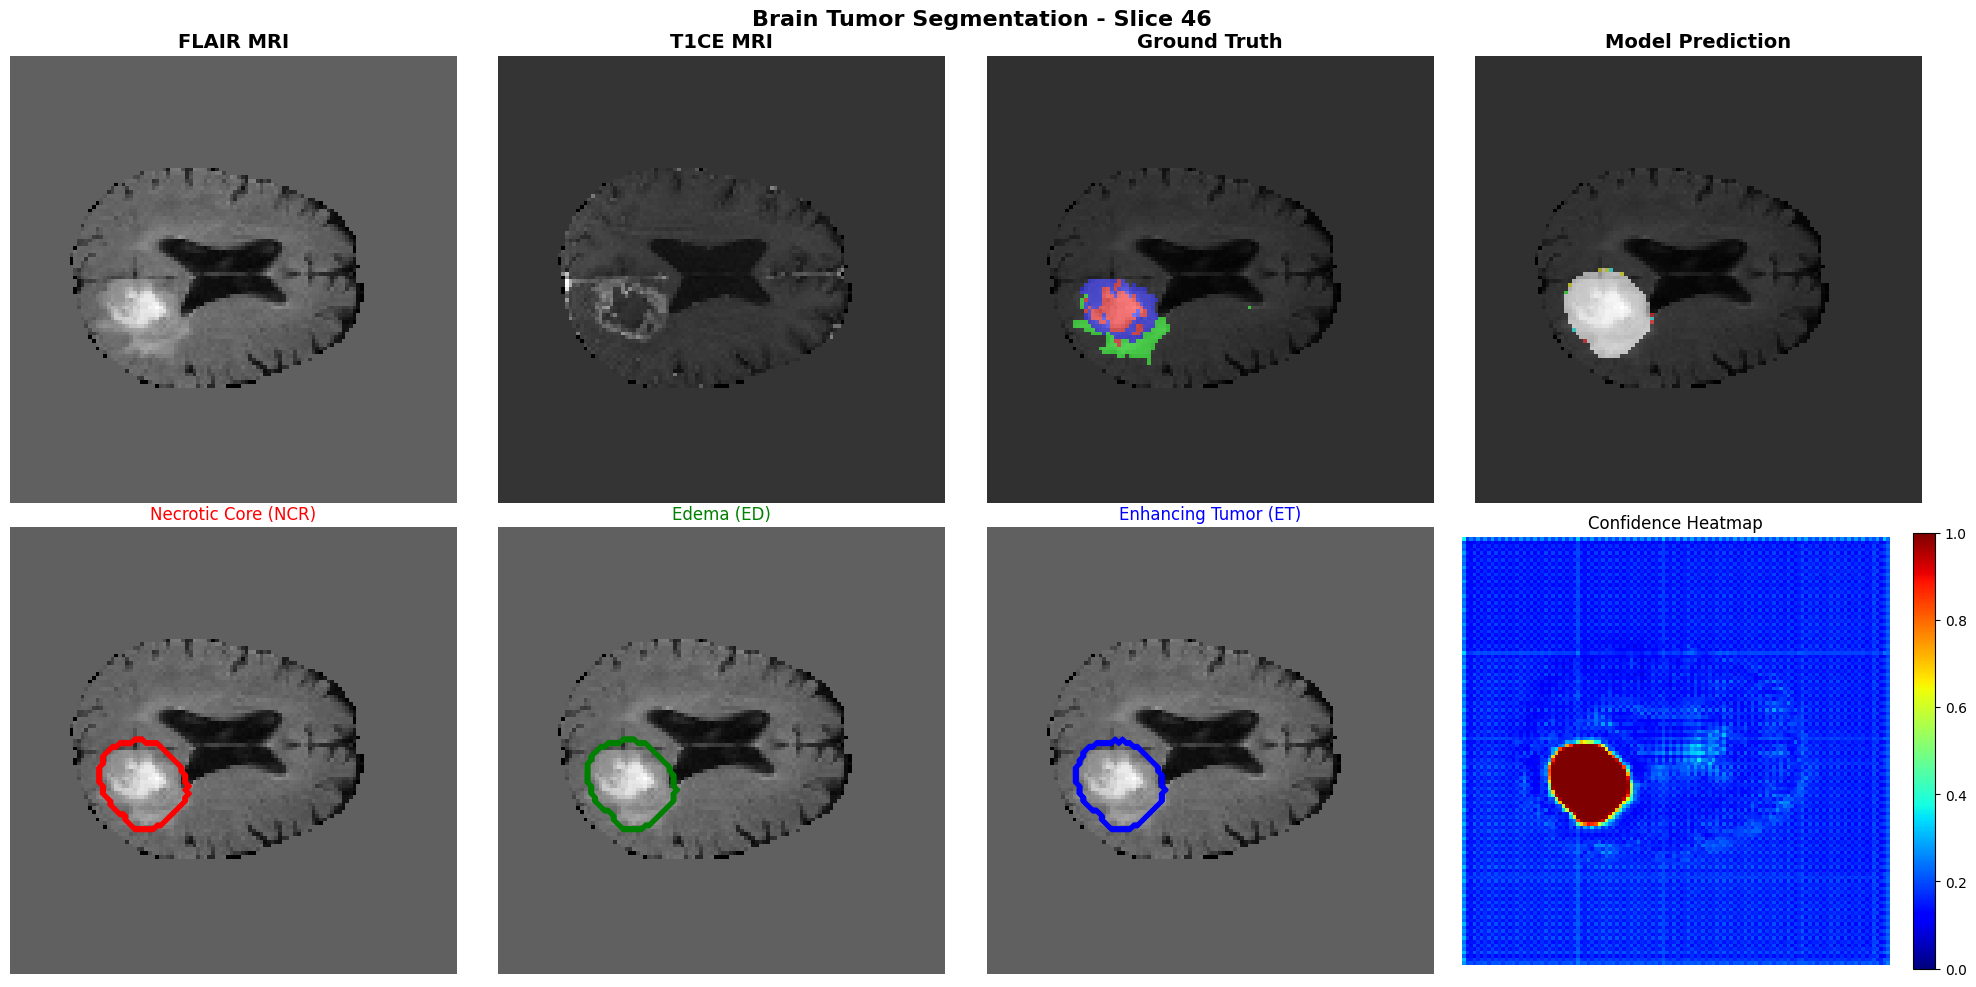

✅ Visualization saved as 'brats_prediction_advanced.png'


In [21]:
def create_advanced_visualization(image, ground_truth, prediction, slice_idx=None):
    """Create publication-quality visualization"""
    
    # Handle both 3D (C, H, W, D) and 4D (1, H, W, D) ground truth
    if ground_truth.ndim == 3:
        gt_3d = ground_truth
    else:
        gt_3d = ground_truth[0] if ground_truth.shape[0] == 1 else ground_truth
    
    # Auto-select slice with most tumor
    if slice_idx is None:
        slice_idx = np.argmax(np.sum(gt_3d > 0, axis=(0, 1)))
    
    # Get middle slice
    img_flair = image[0, :, :, slice_idx]  # FLAIR modality
    img_t1ce = image[2, :, :, slice_idx]   # T1CE modality
    
    # Ground truth (convert from {0,1,2,4} to colored mask)
    gt_slice = gt_3d[:, :, slice_idx]
    gt_colored = np.zeros((*gt_slice.shape, 3))
    gt_colored[gt_slice == 1, 0] = 1  # Red: NCR
    gt_colored[gt_slice == 2, 1] = 1  # Green: Edema
    gt_colored[gt_slice == 4, 2] = 1  # Blue: Enhancing
    
    # Prediction colored
    pred_colored = np.zeros((*prediction.shape[1:3], 3))
    pred_colored[prediction[0, :, :, slice_idx] > 0.5, 0] = 1  # Red
    pred_colored[prediction[1, :, :, slice_idx] > 0.5, 1] = 1  # Green
    pred_colored[prediction[2, :, :, slice_idx] > 0.5, 2] = 1  # Blue
    
    # Create figure
    fig = plt.figure(figsize=(20, 10))
    
    # Row 1: Original images
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(img_flair, cmap='gray')
    ax1.set_title('FLAIR MRI', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(img_t1ce, cmap='gray')
    ax2.set_title('T1CE MRI', fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Row 1: Ground truth overlay
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(img_flair, cmap='gray')
    ax3.imshow(gt_colored, alpha=0.5)
    ax3.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax3.axis('off')
    
    # Row 1: Prediction overlay
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(img_flair, cmap='gray')
    ax4.imshow(pred_colored, alpha=0.5)
    ax4.set_title('Model Prediction', fontsize=14, fontweight='bold')
    ax4.axis('off')
    
    # Row 2: Individual tumor components
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(img_flair, cmap='gray')
    mask = prediction_binary[0, :, :, slice_idx]
    ax5.contour(mask, colors='red', linewidths=2)
    ax5.set_title('Necrotic Core (NCR)', fontsize=12, color='red')
    ax5.axis('off')
    
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(img_flair, cmap='gray')
    mask = prediction_binary[1, :, :, slice_idx]
    ax6.contour(mask, colors='green', linewidths=2)
    ax6.set_title('Edema (ED)', fontsize=12, color='green')
    ax6.axis('off')
    
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(img_flair, cmap='gray')
    mask = prediction_binary[2, :, :, slice_idx]
    ax7.contour(mask, colors='blue', linewidths=2)
    ax7.set_title('Enhancing Tumor (ET)', fontsize=12, color='blue')
    ax7.axis('off')
    
    # Row 2: Heatmap
    ax8 = plt.subplot(2, 4, 8)
    combined_prob = np.max(prediction[:, :, :, slice_idx], axis=0)
    im = ax8.imshow(combined_prob, cmap='jet', vmin=0, vmax=1)
    ax8.set_title('Confidence Heatmap', fontsize=12)
    ax8.axis('off')
    plt.colorbar(im, ax=ax8, fraction=0.046)
    
    plt.suptitle(f'Brain Tumor Segmentation - Slice {slice_idx}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('brats_prediction_advanced.png', dpi=150, bbox_inches='tight')
    plt.show()

# Create visualization
create_advanced_visualization(
    test_image[0].cpu().numpy(),
    test_label,
    prediction  # Use prediction not prediction_binary
)

print("✅ Visualization saved as 'brats_prediction_advanced.png'")


In [22]:
def compute_dice(pred, target, class_idx):
    """Compute Dice score for a specific class"""
    pred_class = (pred[class_idx] > 0.5).astype(np.float32)
    
    # Handle 3D target
    if target.ndim == 3:
        target_2d = target
    else:
        target_2d = target[0] if target.shape[0] == 1 else target
    
    if class_idx == 0:
        target_class = (target_2d == 1).astype(np.float32)
    elif class_idx == 1:
        target_class = (target_2d == 2).astype(np.float32)
    else:
        target_class = (target_2d == 4).astype(np.float32)
    
    intersection = np.sum(pred_class * target_class)
    union = np.sum(pred_class) + np.sum(target_class)
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return 2.0 * intersection / union

dice_ncr = compute_dice(prediction, test_label, 0)
dice_ed = compute_dice(prediction, test_label, 1)
dice_et = compute_dice(prediction, test_label, 2)

print("\n📊 EVALUATION METRICS:")
print(f"   Dice - Necrotic Core (NCR): {dice_ncr:.4f}")
print(f"   Dice - Edema (ED):          {dice_ed:.4f}")
print(f"   Dice - Enhancing Tumor (ET):{dice_et:.4f}")
print(f"   Mean Dice:                  {(dice_ncr + dice_ed + dice_et)/3:.4f}")



📊 EVALUATION METRICS:
   Dice - Necrotic Core (NCR): 0.0722
   Dice - Edema (ED):          0.0781
   Dice - Enhancing Tumor (ET):0.1590
   Mean Dice:                  0.1031


In [23]:
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'spatial_dims': 3,
        'in_channels': 4,
        'out_channels': 3,
        'channels': (16, 32, 64, 128, 256),
        'strides': (2, 2, 2, 2),
        'num_res_units': 2,
    },
    'metrics': {
        'best_dice': best_metric,
        'dice_ncr': dice_ncr,
        'dice_ed': dice_ed,
        'dice_et': dice_et,
    }
}, 'brats_model_complete.pth')

print("\n💾 Model saved as 'brats_model_complete.pth'")
print("   Download this file to use in your Streamlit app!")


💾 Model saved as 'brats_model_complete.pth'
   Download this file to use in your Streamlit app!


In [24]:
sample_data = {
    'image': test_image[0].cpu().numpy(),
    'prediction': prediction,
    'ground_truth': test_label,
    'subject_name': test_subject.name
}

np.save('sample_test_case.npy', sample_data)
print("💾 Sample test case saved as 'sample_test_case.npy'")
print("\n✅ All files ready! Download:")
print("   1. brats_model_complete.pth (model)")
print("   2. brats_prediction_advanced.png (visualization)")
print("   3. sample_test_case.npy (test data)")

💾 Sample test case saved as 'sample_test_case.npy'

✅ All files ready! Download:
   1. brats_model_complete.pth (model)
   2. brats_prediction_advanced.png (visualization)
   3. sample_test_case.npy (test data)


In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from pathlib import Path
import random
from tqdm import tqdm
import gc

from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    NormalizeIntensityd, RandSpatialCropd, RandFlipd, 
    RandRotate90d, RandGaussianNoised, ToTensord, SpatialPadd,
    RandScaleIntensityd, RandShiftIntensityd, Lambdad, RandAffined
)

In [41]:
CONFIG = {
    'data_path': '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData',
    'num_train_samples': 100,  # Increased from 50
    'num_val_samples': 15,
    'batch_size': 2,
    'patch_size': (96, 96, 96),  # Larger patches for better context
    'num_epochs': 50,  # More epochs
    'val_interval': 2,  # Validate more often
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
}

In [42]:
def convert_labels_to_binary(label):
    """Convert BRATS labels to 3-channel binary format"""
    result = torch.zeros((3,) + label.shape[1:], dtype=torch.float32)
    result[0] = (label[0] == 1).float()  # NCR
    result[1] = (label[0] == 2).float()  # ED
    result[2] = (label[0] == 4).float()  # ET
    return result

In [43]:
def get_data_dicts(data_path, num_samples=None):
    data_dir = Path(data_path)
    subjects = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    
    if num_samples:
        subjects = subjects[:num_samples]
    
    data_dicts = []
    for subj in subjects:
        data_dict = {
            'image': [
                str(subj / f'{subj.name}_flair.nii'),
                str(subj / f'{subj.name}_t1.nii'),
                str(subj / f'{subj.name}_t1ce.nii'),
                str(subj / f'{subj.name}_t2.nii'),
            ],
            'label': str(subj / f'{subj.name}_seg.nii'),
        }
        if all(os.path.exists(f) for f in data_dict['image']) and os.path.exists(data_dict['label']):
            data_dicts.append(data_dict)
    
    return data_dicts

In [44]:
def get_transforms(mode='train'):
    if mode == 'train':
        return Compose([
            LoadImaged(keys=['image', 'label']),
            EnsureChannelFirstd(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.5), mode=('bilinear', 'nearest')),
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            SpatialPadd(keys=['image', 'label'], spatial_size=CONFIG['patch_size'], mode='constant'),
            NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
            RandSpatialCropd(keys=['image', 'label'], roi_size=CONFIG['patch_size'], random_size=False),
            Lambdad(keys='label', func=convert_labels_to_binary),
            # More aggressive augmentation
            RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=[0, 1, 2]),
            RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=3, spatial_axes=(0, 1)),
            RandAffined(
                keys=['image', 'label'],
                prob=0.3,
                rotate_range=[0.1, 0.1, 0.1],
                scale_range=[0.1, 0.1, 0.1],
                mode=['bilinear', 'nearest'],
            ),
            RandGaussianNoised(keys='image', prob=0.15, mean=0.0, std=0.1),
            RandScaleIntensityd(keys='image', factors=0.25, prob=0.15),
            RandShiftIntensityd(keys='image', offsets=0.1, prob=0.15),
            ToTensord(keys=['image', 'label']),
        ])
    else:
        return Compose([
            LoadImaged(keys=['image', 'label']),
            EnsureChannelFirstd(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.5), mode=('bilinear', 'nearest')),
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            SpatialPadd(keys=['image', 'label'], spatial_size=CONFIG['patch_size'], mode='constant'),
            NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
            RandSpatialCropd(keys=['image', 'label'], roi_size=CONFIG['patch_size'], random_size=False),
            Lambdad(keys='label', func=convert_labels_to_binary),
            ToTensord(keys=['image', 'label']),
        ])

In [45]:
print("🔍 Loading dataset...")
all_data = get_data_dicts(CONFIG['data_path'])
print(f"Found {len(all_data)} subjects")

random.seed(42)
random.shuffle(all_data)
train_data = all_data[:CONFIG['num_train_samples']]
val_data = all_data[CONFIG['num_train_samples']:CONFIG['num_train_samples']+CONFIG['num_val_samples']]

print(f"📊 Train: {len(train_data)}, Val: {len(val_data)}")

from monai.data import CacheDataset, DataLoader as MonaiDataLoader

train_ds = CacheDataset(data=train_data, transform=get_transforms('train'), cache_rate=0.0)
val_ds = CacheDataset(data=val_data, transform=get_transforms('val'), cache_rate=0.0)

train_loader = MonaiDataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
val_loader = MonaiDataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

🔍 Loading dataset...
Found 368 subjects
📊 Train: 100, Val: 15


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Using device: {device}")

model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),  # Deeper model
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.1,  # Add dropout for regularization
).to(device)

# Combined Dice + Cross Entropy loss works better
loss_function = DiceCELoss(sigmoid=True, squared_pred=True, lambda_dice=0.5, lambda_ce=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

# Learning rate scheduler with warmup
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

warmup_scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=5)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['num_epochs']-5, eta_min=1e-6)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[5])

dice_metric = DiceMetric(include_background=False, reduction='mean', get_not_nans=False)

print(f"✅ Model: {sum(p.numel() for p in model.parameters()):,} parameters")


💻 Using device: cuda
✅ Model: 19,223,978 parameters


In [47]:
best_metric = -1
best_metric_epoch = -1
epoch_losses = []
val_metrics = []
train_metrics = []

print("\n🚀 Starting improved training...\n")

for epoch in range(CONFIG['num_epochs']):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    step = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    for batch_data in pbar:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Compute training Dice
        with torch.no_grad():
            outputs_binary = (torch.sigmoid(outputs) > 0.5).float()
            dice_metric(y_pred=outputs_binary, y=labels)
        
        current_dice = dice_metric.aggregate().item()
        epoch_dice += current_dice
        dice_metric.reset()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{current_dice:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
        
        del inputs, labels, outputs, loss
        
    epoch_loss /= step
    epoch_dice /= step
    epoch_losses.append(epoch_loss)
    train_metrics.append(epoch_dice)
    scheduler.step()
    
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Train Dice: {epoch_dice:.4f}")
    
    # Validation
    if (epoch + 1) % CONFIG['val_interval'] == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_step = 0
            
            for val_data in val_loader:
                val_step += 1
                val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels).item()
                
                val_outputs_binary = (torch.sigmoid(val_outputs) > 0.5).float()
                dice_metric(y_pred=val_outputs_binary, y=val_labels)
                
                del val_inputs, val_labels, val_outputs, val_outputs_binary
            
            val_loss /= val_step
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            
            val_metrics.append(metric)
            
            print(f"✓ Validation - Loss: {val_loss:.4f}, Dice: {metric:.4f}")
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_dice': best_metric,
                    'config': CONFIG,
                }, 'best_model_improved.pth')
                print(f"🎯 New best model! Dice: {best_metric:.4f}")
    
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n✅ Training complete! Best Dice: {best_metric:.4f} at epoch {best_metric_epoch}")



🚀 Starting improved training...



Epoch 1/50: 100%|██████████| 50/50 [02:02<00:00,  2.46s/it, loss=0.4961, dice=0.0243, lr=0.000100]


Epoch 1 - Loss: 0.4985, Train Dice: 0.0262


Epoch 2/50: 100%|██████████| 50/50 [02:05<00:00,  2.50s/it, loss=0.4805, dice=0.0712, lr=0.000280]


Epoch 2 - Loss: 0.4887, Train Dice: 0.0399
✓ Validation - Loss: 0.4842, Dice: 0.0459
🎯 New best model! Dice: 0.0459


Epoch 3/50: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it, loss=0.4629, dice=0.1714, lr=0.000460]


Epoch 3 - Loss: 0.4831, Train Dice: 0.0609


Epoch 4/50: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it, loss=0.4548, dice=0.1537, lr=0.000640]


Epoch 4 - Loss: 0.4827, Train Dice: 0.0628
✓ Validation - Loss: 0.4870, Dice: 0.0435


Epoch 5/50: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it, loss=0.4723, dice=0.0844, lr=0.000820]


Epoch 5 - Loss: 0.4781, Train Dice: 0.0704


Epoch 6/50: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it, loss=0.4242, dice=0.2764, lr=0.001000]


Epoch 6 - Loss: 0.4726, Train Dice: 0.0895
✓ Validation - Loss: 0.4711, Dice: 0.1004
🎯 New best model! Dice: 0.1004


Epoch 7/50: 100%|██████████| 50/50 [02:03<00:00,  2.47s/it, loss=0.4133, dice=0.2629, lr=0.000999]


Epoch 7 - Loss: 0.4477, Train Dice: 0.1983


Epoch 8/50: 100%|██████████| 50/50 [02:02<00:00,  2.46s/it, loss=0.3889, dice=0.3910, lr=0.000995]


Epoch 8 - Loss: 0.3896, Train Dice: 0.3625
✓ Validation - Loss: 0.3558, Dice: 0.5306
🎯 New best model! Dice: 0.5306


Epoch 9/50: 100%|██████████| 50/50 [01:54<00:00,  2.30s/it, loss=0.3444, dice=0.4233, lr=0.000989]


Epoch 9 - Loss: 0.3306, Train Dice: 0.5085


Epoch 10/50: 100%|██████████| 50/50 [02:03<00:00,  2.47s/it, loss=0.2404, dice=0.7466, lr=0.000981]


Epoch 10 - Loss: 0.2775, Train Dice: 0.5499
✓ Validation - Loss: 0.2664, Dice: 0.5292


Epoch 11/50: 100%|██████████| 50/50 [02:00<00:00,  2.40s/it, loss=0.2507, dice=0.6234, lr=0.000970]


Epoch 11 - Loss: 0.2648, Train Dice: 0.5537


Epoch 12/50: 100%|██████████| 50/50 [02:02<00:00,  2.44s/it, loss=0.3221, dice=0.4553, lr=0.000957]


Epoch 12 - Loss: 0.2575, Train Dice: 0.5571
✓ Validation - Loss: 0.2323, Dice: 0.6018
🎯 New best model! Dice: 0.6018


Epoch 13/50: 100%|██████████| 50/50 [01:59<00:00,  2.40s/it, loss=0.2264, dice=0.6764, lr=0.000942]


Epoch 13 - Loss: 0.2534, Train Dice: 0.5802


Epoch 14/50: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it, loss=0.3494, dice=0.3704, lr=0.000924]


Epoch 14 - Loss: 0.2386, Train Dice: 0.5832
✓ Validation - Loss: 0.2292, Dice: 0.5941


Epoch 15/50: 100%|██████████| 50/50 [02:06<00:00,  2.53s/it, loss=0.2028, dice=0.6232, lr=0.000905]


Epoch 15 - Loss: 0.2239, Train Dice: 0.6124


Epoch 16/50: 100%|██████████| 50/50 [02:04<00:00,  2.48s/it, loss=0.1700, dice=0.7083, lr=0.000883]


Epoch 16 - Loss: 0.2229, Train Dice: 0.6229
✓ Validation - Loss: 0.2213, Dice: 0.5959


Epoch 17/50: 100%|██████████| 50/50 [02:06<00:00,  2.52s/it, loss=0.2092, dice=0.6482, lr=0.000860]


Epoch 17 - Loss: 0.2208, Train Dice: 0.6343


Epoch 18/50: 100%|██████████| 50/50 [02:04<00:00,  2.50s/it, loss=0.2089, dice=0.5366, lr=0.000835]


Epoch 18 - Loss: 0.2187, Train Dice: 0.6244
✓ Validation - Loss: 0.2556, Dice: 0.5367


Epoch 19/50: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it, loss=0.2181, dice=0.6966, lr=0.000808]


Epoch 19 - Loss: 0.2203, Train Dice: 0.6189


Epoch 20/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.1609, dice=0.7565, lr=0.000780]


Epoch 20 - Loss: 0.2111, Train Dice: 0.6490
✓ Validation - Loss: 0.2204, Dice: 0.5861


Epoch 21/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.1648, dice=0.8278, lr=0.000750]


Epoch 21 - Loss: 0.2104, Train Dice: 0.6395


Epoch 22/50: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it, loss=0.1972, dice=0.6087, lr=0.000719]


Epoch 22 - Loss: 0.2080, Train Dice: 0.6540
✓ Validation - Loss: 0.2207, Dice: 0.5764


Epoch 23/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.3392, dice=0.2513, lr=0.000688]


Epoch 23 - Loss: 0.2068, Train Dice: 0.6567


Epoch 24/50: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it, loss=0.2549, dice=0.6235, lr=0.000655]


Epoch 24 - Loss: 0.1934, Train Dice: 0.6798
✓ Validation - Loss: 0.1982, Dice: 0.6133
🎯 New best model! Dice: 0.6133


Epoch 25/50: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it, loss=0.1420, dice=0.7463, lr=0.000621]


Epoch 25 - Loss: 0.2007, Train Dice: 0.6660


Epoch 26/50: 100%|██████████| 50/50 [02:06<00:00,  2.54s/it, loss=0.2305, dice=0.5489, lr=0.000587]


Epoch 26 - Loss: 0.2007, Train Dice: 0.6563
✓ Validation - Loss: 0.2118, Dice: 0.6289
🎯 New best model! Dice: 0.6289


Epoch 27/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.2154, dice=0.6216, lr=0.000553]


Epoch 27 - Loss: 0.1933, Train Dice: 0.6652


Epoch 28/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.1516, dice=0.6970, lr=0.000518]


Epoch 28 - Loss: 0.1890, Train Dice: 0.6677
✓ Validation - Loss: 0.1988, Dice: 0.6533
🎯 New best model! Dice: 0.6533


Epoch 29/50: 100%|██████████| 50/50 [01:59<00:00,  2.39s/it, loss=0.1753, dice=0.6535, lr=0.000483]


Epoch 29 - Loss: 0.1852, Train Dice: 0.6789


Epoch 30/50: 100%|██████████| 50/50 [02:03<00:00,  2.47s/it, loss=0.2018, dice=0.6754, lr=0.000448]


Epoch 30 - Loss: 0.1829, Train Dice: 0.6831
✓ Validation - Loss: 0.1990, Dice: 0.6316


Epoch 31/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.2771, dice=0.5224, lr=0.000414]


Epoch 31 - Loss: 0.1758, Train Dice: 0.7050


Epoch 32/50: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it, loss=0.1640, dice=0.5736, lr=0.000380]


Epoch 32 - Loss: 0.1872, Train Dice: 0.6735
✓ Validation - Loss: 0.1892, Dice: 0.6256


Epoch 33/50: 100%|██████████| 50/50 [02:04<00:00,  2.48s/it, loss=0.2098, dice=0.6558, lr=0.000346]


Epoch 33 - Loss: 0.1810, Train Dice: 0.6898


Epoch 34/50: 100%|██████████| 50/50 [02:04<00:00,  2.48s/it, loss=0.1385, dice=0.7741, lr=0.000313]


Epoch 34 - Loss: 0.1782, Train Dice: 0.6920
✓ Validation - Loss: 0.1877, Dice: 0.6537
🎯 New best model! Dice: 0.6537


Epoch 35/50: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it, loss=0.1992, dice=0.6870, lr=0.000282]


Epoch 35 - Loss: 0.1664, Train Dice: 0.7054


Epoch 36/50: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it, loss=0.1574, dice=0.6757, lr=0.000251]


Epoch 36 - Loss: 0.1659, Train Dice: 0.7166
✓ Validation - Loss: 0.1731, Dice: 0.6649
🎯 New best model! Dice: 0.6649


Epoch 37/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.1934, dice=0.6567, lr=0.000221]


Epoch 37 - Loss: 0.1676, Train Dice: 0.7141


Epoch 38/50: 100%|██████████| 50/50 [02:04<00:00,  2.48s/it, loss=0.3620, dice=0.5859, lr=0.000193]


Epoch 38 - Loss: 0.1702, Train Dice: 0.7108
✓ Validation - Loss: 0.2181, Dice: 0.6084


Epoch 39/50: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it, loss=0.0867, dice=0.8557, lr=0.000166]


Epoch 39 - Loss: 0.1692, Train Dice: 0.7068


Epoch 40/50: 100%|██████████| 50/50 [02:06<00:00,  2.52s/it, loss=0.2582, dice=0.4204, lr=0.000141]


Epoch 40 - Loss: 0.1686, Train Dice: 0.7088
✓ Validation - Loss: 0.1738, Dice: 0.6704
🎯 New best model! Dice: 0.6704


Epoch 41/50: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it, loss=0.1371, dice=0.7159, lr=0.000118]


Epoch 41 - Loss: 0.1594, Train Dice: 0.7177


Epoch 42/50: 100%|██████████| 50/50 [02:04<00:00,  2.50s/it, loss=0.1090, dice=0.8166, lr=0.000096]


Epoch 42 - Loss: 0.1612, Train Dice: 0.7173
✓ Validation - Loss: 0.1676, Dice: 0.6774
🎯 New best model! Dice: 0.6774


Epoch 43/50: 100%|██████████| 50/50 [02:07<00:00,  2.55s/it, loss=0.1783, dice=0.5708, lr=0.000077]


Epoch 43 - Loss: 0.1588, Train Dice: 0.7158


Epoch 44/50: 100%|██████████| 50/50 [02:07<00:00,  2.55s/it, loss=0.1509, dice=0.6921, lr=0.000059]


Epoch 44 - Loss: 0.1591, Train Dice: 0.7220
✓ Validation - Loss: 0.1667, Dice: 0.6744


Epoch 45/50: 100%|██████████| 50/50 [02:03<00:00,  2.47s/it, loss=0.1776, dice=0.7194, lr=0.000044]


Epoch 45 - Loss: 0.1651, Train Dice: 0.7179


Epoch 46/50: 100%|██████████| 50/50 [02:04<00:00,  2.50s/it, loss=0.2317, dice=0.5853, lr=0.000031]


Epoch 46 - Loss: 0.1547, Train Dice: 0.7254
✓ Validation - Loss: 0.1712, Dice: 0.6793
🎯 New best model! Dice: 0.6793


Epoch 47/50: 100%|██████████| 50/50 [02:04<00:00,  2.50s/it, loss=0.1928, dice=0.6625, lr=0.000020]


Epoch 47 - Loss: 0.1622, Train Dice: 0.7217


Epoch 48/50: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it, loss=0.0934, dice=0.7660, lr=0.000012]


Epoch 48 - Loss: 0.1656, Train Dice: 0.7107
✓ Validation - Loss: 0.1793, Dice: 0.6642


Epoch 49/50: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=0.1254, dice=0.7530, lr=0.000006]


Epoch 49 - Loss: 0.1573, Train Dice: 0.7244


Epoch 50/50: 100%|██████████| 50/50 [02:02<00:00,  2.44s/it, loss=0.2191, dice=0.7520, lr=0.000002]


Epoch 50 - Loss: 0.1628, Train Dice: 0.7155
✓ Validation - Loss: 0.1691, Dice: 0.6733

✅ Training complete! Best Dice: 0.6793 at epoch 46


In [54]:
import torch

checkpoint = torch.load("best_model_improved.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ Best model loaded from epoch:", checkpoint["epoch"])
print("✅ Best validation Dice:", checkpoint["best_dice"])


✅ Best model loaded from epoch: 45
✅ Best validation Dice: 0.6793187260627747


✅ Saved training_metrics.png


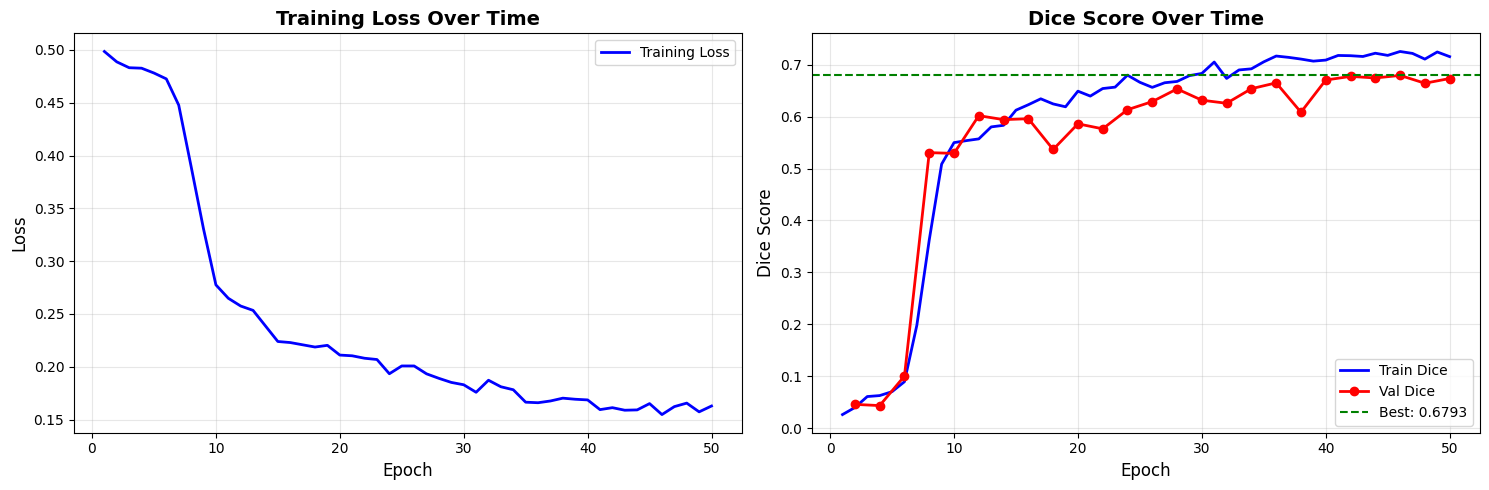

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
axes[0].plot(range(1, len(epoch_losses) + 1), epoch_losses, 'b-', linewidth=2, label='Training Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Dice Score (Train and Val)
axes[1].plot(range(1, len(train_metrics) + 1), train_metrics, 'b-', linewidth=2, label='Train Dice')
# Plot validation metrics at correct intervals
val_epochs = [i * CONFIG['val_interval'] for i in range(1, len(val_metrics) + 1)]
axes[1].plot(val_epochs, val_metrics, 'r-', linewidth=2, marker='o', label='Val Dice')
axes[1].axhline(y=best_metric, color='g', linestyle='--', label=f'Best: {best_metric:.4f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Score', fontsize=12)
axes[1].set_title('Dice Score Over Time', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
print("✅ Saved training_metrics.png")
plt.show()

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import random
from tqdm import tqdm
import gc
import nibabel as nib

from monai.networks.nets import SegResNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    NormalizeIntensityd, RandSpatialCropd, RandFlipd, 
    RandRotate90d, RandGaussianNoised, ToTensord, SpatialPadd,
    RandScaleIntensityd, RandShiftIntensityd, Lambdad, RandAffined,
    RandGaussianSmoothd, RandAdjustContrastd
)
from monai.data import CacheDataset, DataLoader as MonaiDataLoader


In [10]:
torch.cuda.empty_cache()
gc.collect()

# Set memory allocation strategy
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print("✅ GPU memory cleared and optimized")

✅ GPU memory cleared and optimized


In [11]:
from monai.networks.nets import SegResNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    NormalizeIntensityd, RandSpatialCropd, RandFlipd, 
    RandRotate90d, RandGaussianNoised, ToTensord, SpatialPadd,
    RandScaleIntensityd, RandShiftIntensityd, Lambdad, RandAffined,
    RandGaussianSmoothd, RandAdjustContrastd
)
from monai.data import CacheDataset, DataLoader as MonaiDataLoader


In [12]:
CONFIG = {
    'data_path': '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData',
    'num_train_samples': 120,  # Increased from 80
    'num_val_samples': 20,     # Increased from 15
    'batch_size': 1,           # REDUCED: 1 instead of 2
    'patch_size': (96, 96, 96),  # REDUCED: 96 instead of 128 to save memory
    'num_epochs': 45,          # Your requested epochs
    'val_interval': 2,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'warmup_epochs': 5,
}

In [13]:
def convert_labels_to_binary(label):
    result = torch.zeros((3,) + label.shape[1:], dtype=torch.float32)
    result[0] = (label[0] == 1).float()
    result[1] = (label[0] == 2).float()
    result[2] = (label[0] == 4).float()
    return result

def get_data_dicts(data_path, num_samples=None):
    data_dir = Path(data_path)
    subjects = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    if num_samples:
        subjects = subjects[:num_samples]
    data_dicts = []
    for subj in subjects:
        data_dict = {
            'image': [
                str(subj / f'{subj.name}_flair.nii'),
                str(subj / f'{subj.name}_t1.nii'),
                str(subj / f'{subj.name}_t1ce.nii'),
                str(subj / f'{subj.name}_t2.nii'),
            ],
            'label': str(subj / f'{subj.name}_seg.nii'),
        }
        if all(os.path.exists(f) for f in data_dict['image']) and os.path.exists(data_dict['label']):
            data_dicts.append(data_dict)
    return data_dicts


In [14]:
def get_transforms(mode='train'):
    if mode == 'train':
        return Compose([
            LoadImaged(keys=['image', 'label']),
            EnsureChannelFirstd(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(1.0, 1.0, 1.0), mode=('bilinear', 'nearest')),  # Higher resolution
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            SpatialPadd(keys=['image', 'label'], spatial_size=CONFIG['patch_size'], mode='constant'),
            NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
            RandSpatialCropd(keys=['image', 'label'], roi_size=CONFIG['patch_size'], random_size=False),
            Lambdad(keys='label', func=convert_labels_to_binary),
            
            # IMPROVED AUGMENTATIONS
            RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=[0, 1, 2]),
            RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=3, spatial_axes=(0, 1)),
            RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=3, spatial_axes=(0, 2)),
            RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=3, spatial_axes=(1, 2)),
            
            # Affine transformations
            RandAffined(
                keys=['image', 'label'],
                prob=0.4,
                rotate_range=[0.15, 0.15, 0.15],
                scale_range=[0.15, 0.15, 0.15],
                translate_range=[15, 15, 15],
                mode=['bilinear', 'nearest'],
            ),
            
            # Intensity augmentations
            RandGaussianNoised(keys='image', prob=0.2, mean=0.0, std=0.1),
            RandScaleIntensityd(keys='image', factors=0.3, prob=0.2),
            RandShiftIntensityd(keys='image', offsets=0.2, prob=0.2),
            RandGaussianSmoothd(keys='image', prob=0.2, sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0), sigma_z=(0.5, 1.0)),
            RandAdjustContrastd(keys='image', prob=0.2, gamma=(0.8, 1.2)),
            
            ToTensord(keys=['image', 'label']),
        ])
    else:
        return Compose([
            LoadImaged(keys=['image', 'label']),
            EnsureChannelFirstd(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(1.0, 1.0, 1.0), mode=('bilinear', 'nearest')),
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            SpatialPadd(keys=['image', 'label'], spatial_size=CONFIG['patch_size'], mode='constant'),
            NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
            RandSpatialCropd(keys=['image', 'label'], roi_size=CONFIG['patch_size'], random_size=False),
            Lambdad(keys='label', func=convert_labels_to_binary),
            ToTensord(keys=['image', 'label']),
        ])

In [15]:
print("🔍 Loading dataset...")
all_data = get_data_dicts(CONFIG['data_path'])
print(f"Found {len(all_data)} subjects")

random.seed(42)
random.shuffle(all_data)
train_data = all_data[:CONFIG['num_train_samples']]
val_data = all_data[CONFIG['num_train_samples']:CONFIG['num_train_samples']+CONFIG['num_val_samples']]

print(f"📊 Train: {len(train_data)}, Val: {len(val_data)}")

train_ds = CacheDataset(data=train_data, transform=get_transforms('train'), cache_rate=0.0)
val_ds = CacheDataset(data=val_data, transform=get_transforms('val'), cache_rate=0.0)

train_loader = MonaiDataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
val_loader = MonaiDataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)


🔍 Loading dataset...
Found 368 subjects
📊 Train: 120, Val: 20


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Using device: {device}")

model = SegResNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    init_filters=32,           # REDUCED: 32 instead of 48 to save memory
    blocks_down=[1, 2, 2, 4],  # REDUCED: Original 4 blocks instead of 5
    blocks_up=[1, 1, 1],       # Original architecture
    dropout_prob=0.15,         # Reduced dropout for better learning
    norm='INSTANCE',           # Instance normalization
).to(device)

# Combined loss for better performance
loss_function = DiceCELoss(
    sigmoid=True,
    squared_pred=True,
    lambda_dice=0.7,  # More weight on Dice
    lambda_ce=0.3
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    betas=(0.9, 0.999)
)

# Advanced learning rate scheduler with warmup
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=CONFIG['warmup_epochs']
)

cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=CONFIG['num_epochs'] - CONFIG['warmup_epochs'],
    eta_min=1e-6
)

scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[CONFIG['warmup_epochs']]
)

dice_metric = DiceMetric(include_background=False, reduction='mean', get_not_nans=False)

print(f"✅ Improved SegResNet: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"🎯 Target: 45 epochs, Dice > 0.75")


💻 Using device: cuda
✅ Improved SegResNet: 18,791,907 parameters
🎯 Target: 45 epochs, Dice > 0.75


In [17]:
best_metric = -1
best_metric_epoch = -1
epoch_losses = []
val_metrics = []
train_dice_scores = []
learning_rates = []

# Early stopping
patience = 10
patience_counter = 0
min_delta = 0.001

print("\n🚀 Starting improved SegResNet training (45 epochs)...\n")

for epoch in range(CONFIG['num_epochs']):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    step = 0
    
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    for batch_data in pbar:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate training Dice
        with torch.no_grad():
            outputs_binary = (torch.sigmoid(outputs) > 0.5).float()
            dice_metric(y_pred=outputs_binary, y=labels)
            train_dice = dice_metric.aggregate().item()
            epoch_dice += train_dice
            dice_metric.reset()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{train_dice:.4f}',
            'lr': f'{current_lr:.6f}'
        })
        
        del inputs, labels, outputs, loss
    
    epoch_loss /= step
    epoch_dice /= step
    epoch_losses.append(epoch_loss)
    train_dice_scores.append(epoch_dice)
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Loss: {epoch_loss:.4f}, Train Dice: {epoch_dice:.4f}, LR: {current_lr:.6f}")
    
    # Validation
    if (epoch + 1) % CONFIG['val_interval'] == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_step = 0
            
            for val_data in val_loader:
                val_step += 1
                val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels).item()
                
                val_outputs_binary = (torch.sigmoid(val_outputs) > 0.5).float()
                dice_metric(y_pred=val_outputs_binary, y=val_labels)
                
                del val_inputs, val_labels, val_outputs, val_outputs_binary
            
            val_loss /= val_step
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            
            val_metrics.append(metric)
            
            print(f"✓ Validation - Loss: {val_loss:.4f}, Dice: {metric:.4f}")
            
            # Save best model
            if metric > best_metric + min_delta:
                best_metric = metric
                best_metric_epoch = epoch + 1
                patience_counter = 0
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_dice': best_metric,
                    'model_type': 'SegResNet_Improved',
                    'model_config': {
                        'spatial_dims': 3,
                        'in_channels': 4,
                        'out_channels': 3,
                        'init_filters': 32,
                        'blocks_down': [1, 2, 2, 4],
                        'blocks_up': [1, 1, 1],
                        'dropout_prob': 0.15,
                    },
                    'training_config': CONFIG,
                }, 'segresnet_improved_best.pth')
                
                print(f"🎯 New best model! Dice: {best_metric:.4f}")
            else:
                patience_counter += 1
                print(f"Patience: {patience_counter}/{patience}")
            
            # Early stopping check
            if patience_counter >= patience:
                print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
                print(f"No improvement for {patience} validation checks")
                break
    
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n✅ Training complete!")
print(f"🏆 Best Dice: {best_metric:.4f} at epoch {best_metric_epoch}")
print(f"📈 Improvement over baseline: +{(best_metric - 0.52)*100:.1f}%")



🚀 Starting improved SegResNet training (45 epochs)...



Epoch 1/45: 100%|██████████| 120/120 [05:47<00:00,  2.89s/it, loss=0.6803, dice=0.1393, lr=0.000010]


Epoch 1/45 - Loss: 0.6683, Train Dice: 0.1157, LR: 0.000010


Epoch 2/45: 100%|██████████| 120/120 [02:47<00:00,  1.40s/it, loss=0.6889, dice=0.0464, lr=0.000028]


Epoch 2/45 - Loss: 0.6482, Train Dice: 0.1908, LR: 0.000028
✓ Validation - Loss: 0.6404, Dice: 0.3202
🎯 New best model! Dice: 0.3202


Epoch 3/45: 100%|██████████| 120/120 [02:37<00:00,  1.32s/it, loss=0.6019, dice=0.4472, lr=0.000046]


Epoch 3/45 - Loss: 0.6511, Train Dice: 0.1909, LR: 0.000046


Epoch 4/45: 100%|██████████| 120/120 [02:34<00:00,  1.29s/it, loss=0.6620, dice=0.1184, lr=0.000064]


Epoch 4/45 - Loss: 0.6361, Train Dice: 0.2486, LR: 0.000064
✓ Validation - Loss: 0.6564, Dice: 0.2845
Patience: 1/10


Epoch 5/45: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it, loss=0.5930, dice=0.6051, lr=0.000082]


Epoch 5/45 - Loss: 0.6387, Train Dice: 0.2449, LR: 0.000082


Epoch 6/45: 100%|██████████| 120/120 [02:40<00:00,  1.33s/it, loss=0.6183, dice=0.4776, lr=0.000100]


Epoch 6/45 - Loss: 0.6279, Train Dice: 0.2880, LR: 0.000100
✓ Validation - Loss: 0.6495, Dice: 0.3326
🎯 New best model! Dice: 0.3326


Epoch 7/45: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it, loss=0.6666, dice=0.1630, lr=0.000100]


Epoch 7/45 - Loss: 0.6313, Train Dice: 0.2782, LR: 0.000100


Epoch 8/45: 100%|██████████| 120/120 [02:36<00:00,  1.31s/it, loss=0.4422, dice=0.8835, lr=0.000099]


Epoch 8/45 - Loss: 0.6181, Train Dice: 0.2882, LR: 0.000099
✓ Validation - Loss: 0.6113, Dice: 0.4631
🎯 New best model! Dice: 0.4631


Epoch 9/45: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it, loss=0.7000, dice=0.0000, lr=0.000099]


Epoch 9/45 - Loss: 0.6193, Train Dice: 0.2906, LR: 0.000099


Epoch 10/45: 100%|██████████| 120/120 [02:39<00:00,  1.33s/it, loss=0.4314, dice=0.7362, lr=0.000098]


Epoch 10/45 - Loss: 0.6000, Train Dice: 0.3457, LR: 0.000098
✓ Validation - Loss: 0.6050, Dice: 0.4445
Patience: 1/10


Epoch 11/45: 100%|██████████| 120/120 [02:33<00:00,  1.28s/it, loss=0.4311, dice=0.7156, lr=0.000096]


Epoch 11/45 - Loss: 0.5882, Train Dice: 0.3575, LR: 0.000096


Epoch 12/45: 100%|██████████| 120/120 [02:37<00:00,  1.32s/it, loss=0.5532, dice=0.5731, lr=0.000095]


Epoch 12/45 - Loss: 0.5963, Train Dice: 0.3293, LR: 0.000095
✓ Validation - Loss: 0.6010, Dice: 0.4454
Patience: 2/10


Epoch 13/45: 100%|██████████| 120/120 [02:32<00:00,  1.27s/it, loss=0.6765, dice=0.1345, lr=0.000093]


Epoch 13/45 - Loss: 0.5884, Train Dice: 0.3748, LR: 0.000093


Epoch 14/45: 100%|██████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.7000, dice=0.0000, lr=0.000091]


Epoch 14/45 - Loss: 0.5813, Train Dice: 0.3654, LR: 0.000091
✓ Validation - Loss: 0.5788, Dice: 0.5846
🎯 New best model! Dice: 0.5846


Epoch 15/45: 100%|██████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.7000, dice=0.0000, lr=0.000088]


Epoch 15/45 - Loss: 0.5778, Train Dice: 0.3620, LR: 0.000088


Epoch 16/45: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it, loss=0.4137, dice=0.7772, lr=0.000086]


Epoch 16/45 - Loss: 0.5709, Train Dice: 0.3470, LR: 0.000086
✓ Validation - Loss: 0.5717, Dice: 0.5221
Patience: 1/10


Epoch 17/45: 100%|██████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.4530, dice=0.7822, lr=0.000083]


Epoch 17/45 - Loss: 0.5389, Train Dice: 0.4635, LR: 0.000083


Epoch 18/45: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it, loss=0.4091, dice=0.8637, lr=0.000080]


Epoch 18/45 - Loss: 0.5701, Train Dice: 0.3612, LR: 0.000080
✓ Validation - Loss: 0.5383, Dice: 0.6303
🎯 New best model! Dice: 0.6303


Epoch 19/45: 100%|██████████| 120/120 [02:40<00:00,  1.33s/it, loss=0.6919, dice=0.2130, lr=0.000076]


Epoch 19/45 - Loss: 0.5574, Train Dice: 0.3790, LR: 0.000076


Epoch 20/45: 100%|██████████| 120/120 [02:36<00:00,  1.31s/it, loss=0.5293, dice=0.4479, lr=0.000073]


Epoch 20/45 - Loss: 0.5551, Train Dice: 0.3662, LR: 0.000073
✓ Validation - Loss: 0.5829, Dice: 0.4581
Patience: 1/10


Epoch 21/45: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it, loss=0.7000, dice=0.0000, lr=0.000069]


Epoch 21/45 - Loss: 0.5481, Train Dice: 0.3803, LR: 0.000069


Epoch 22/45: 100%|██████████| 120/120 [02:40<00:00,  1.34s/it, loss=0.5540, dice=0.5330, lr=0.000066]


Epoch 22/45 - Loss: 0.5214, Train Dice: 0.4256, LR: 0.000066
✓ Validation - Loss: 0.5192, Dice: 0.5483
Patience: 2/10


Epoch 23/45: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it, loss=0.6084, dice=0.3875, lr=0.000062]


Epoch 23/45 - Loss: 0.5231, Train Dice: 0.3966, LR: 0.000062


Epoch 24/45: 100%|██████████| 120/120 [02:40<00:00,  1.33s/it, loss=0.5229, dice=0.3096, lr=0.000058]


Epoch 24/45 - Loss: 0.4966, Train Dice: 0.4740, LR: 0.000058
✓ Validation - Loss: 0.5345, Dice: 0.5329
Patience: 3/10


Epoch 25/45: 100%|██████████| 120/120 [02:37<00:00,  1.32s/it, loss=0.6773, dice=0.2773, lr=0.000054]


Epoch 25/45 - Loss: 0.5083, Train Dice: 0.4522, LR: 0.000054


Epoch 26/45: 100%|██████████| 120/120 [02:37<00:00,  1.32s/it, loss=0.4124, dice=0.4508, lr=0.000050]


Epoch 26/45 - Loss: 0.5189, Train Dice: 0.4168, LR: 0.000050
✓ Validation - Loss: 0.5093, Dice: 0.5805
Patience: 4/10


Epoch 27/45: 100%|██████████| 120/120 [02:33<00:00,  1.28s/it, loss=0.6993, dice=0.0000, lr=0.000047]


Epoch 27/45 - Loss: 0.5030, Train Dice: 0.4157, LR: 0.000047


Epoch 28/45: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it, loss=0.2767, dice=0.7578, lr=0.000043]


Epoch 28/45 - Loss: 0.4854, Train Dice: 0.4802, LR: 0.000043
✓ Validation - Loss: 0.5041, Dice: 0.6247
Patience: 5/10


Epoch 29/45: 100%|██████████| 120/120 [02:35<00:00,  1.29s/it, loss=0.7000, dice=0.0000, lr=0.000039]


Epoch 29/45 - Loss: 0.5128, Train Dice: 0.4271, LR: 0.000039


Epoch 30/45: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it, loss=0.6179, dice=0.6786, lr=0.000035]


Epoch 30/45 - Loss: 0.4787, Train Dice: 0.4931, LR: 0.000035
✓ Validation - Loss: 0.4859, Dice: 0.7177
🎯 New best model! Dice: 0.7177


Epoch 31/45: 100%|██████████| 120/120 [02:40<00:00,  1.34s/it, loss=0.7000, dice=0.0000, lr=0.000032]


Epoch 31/45 - Loss: 0.4821, Train Dice: 0.4772, LR: 0.000032


Epoch 32/45: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it, loss=0.6144, dice=0.3564, lr=0.000028]


Epoch 32/45 - Loss: 0.4783, Train Dice: 0.4857, LR: 0.000028
✓ Validation - Loss: 0.5086, Dice: 0.6184
Patience: 1/10


Epoch 33/45: 100%|██████████| 120/120 [02:33<00:00,  1.28s/it, loss=0.6504, dice=0.1881, lr=0.000025]


Epoch 33/45 - Loss: 0.4823, Train Dice: 0.4792, LR: 0.000025


Epoch 34/45: 100%|██████████| 120/120 [02:35<00:00,  1.30s/it, loss=0.5384, dice=0.3831, lr=0.000021]


Epoch 34/45 - Loss: 0.4929, Train Dice: 0.4328, LR: 0.000021
✓ Validation - Loss: 0.4422, Dice: 0.7411
🎯 New best model! Dice: 0.7411


Epoch 35/45: 100%|██████████| 120/120 [02:35<00:00,  1.30s/it, loss=0.7000, dice=0.0000, lr=0.000018]


Epoch 35/45 - Loss: 0.4848, Train Dice: 0.4614, LR: 0.000018


Epoch 36/45: 100%|██████████| 120/120 [02:37<00:00,  1.32s/it, loss=0.3432, dice=0.6122, lr=0.000015]


Epoch 36/45 - Loss: 0.4706, Train Dice: 0.4744, LR: 0.000015
✓ Validation - Loss: 0.5615, Dice: 0.4857
Patience: 1/10


Epoch 37/45: 100%|██████████| 120/120 [02:36<00:00,  1.30s/it, loss=0.4090, dice=0.4296, lr=0.000013]


Epoch 37/45 - Loss: 0.4692, Train Dice: 0.5090, LR: 0.000013


Epoch 38/45: 100%|██████████| 120/120 [02:35<00:00,  1.30s/it, loss=0.7000, dice=0.0000, lr=0.000010]


Epoch 38/45 - Loss: 0.4867, Train Dice: 0.4737, LR: 0.000010
✓ Validation - Loss: 0.4749, Dice: 0.5795
Patience: 2/10


Epoch 39/45: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it, loss=0.2364, dice=0.8845, lr=0.000008]


Epoch 39/45 - Loss: 0.4749, Train Dice: 0.4673, LR: 0.000008


Epoch 40/45: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it, loss=0.7000, dice=0.0000, lr=0.000006]


Epoch 40/45 - Loss: 0.4868, Train Dice: 0.4481, LR: 0.000006
✓ Validation - Loss: 0.4684, Dice: 0.6536
Patience: 3/10


Epoch 41/45: 100%|██████████| 120/120 [02:39<00:00,  1.33s/it, loss=0.3641, dice=0.8606, lr=0.000005]


Epoch 41/45 - Loss: 0.4661, Train Dice: 0.4940, LR: 0.000005


Epoch 42/45: 100%|██████████| 120/120 [02:36<00:00,  1.30s/it, loss=0.4071, dice=0.8109, lr=0.000003]


Epoch 42/45 - Loss: 0.4726, Train Dice: 0.4993, LR: 0.000003
✓ Validation - Loss: 0.4464, Dice: 0.6762
Patience: 4/10


Epoch 43/45: 100%|██████████| 120/120 [02:36<00:00,  1.30s/it, loss=0.4922, dice=0.4208, lr=0.000002]


Epoch 43/45 - Loss: 0.4621, Train Dice: 0.5040, LR: 0.000002


Epoch 44/45: 100%|██████████| 120/120 [02:34<00:00,  1.29s/it, loss=0.2156, dice=0.7836, lr=0.000002]


Epoch 44/45 - Loss: 0.4577, Train Dice: 0.5009, LR: 0.000002
✓ Validation - Loss: 0.4645, Dice: 0.6754
Patience: 5/10


Epoch 45/45: 100%|██████████| 120/120 [02:31<00:00,  1.27s/it, loss=0.3514, dice=0.8295, lr=0.000001]


Epoch 45/45 - Loss: 0.4673, Train Dice: 0.4794, LR: 0.000001

✅ Training complete!
🏆 Best Dice: 0.7411 at epoch 34
📈 Improvement over baseline: +22.1%


In [18]:
print("\n Saving complete model for Streamlit...")
torch.save({
    'model_state_dict': model.state_dict(),
    'model_type': 'SegResNet_Improved',
    'model_config': {
        'spatial_dims': 3,
        'in_channels': 4,
        'out_channels': 3,
        'init_filters': 32,
        'blocks_down': [1, 2, 2, 4],
        'blocks_up': [1, 1, 1],
        'dropout_prob': 0.15,
    },
    'best_dice': best_metric,
    'final_dice': val_metrics[-1] if val_metrics else best_metric,
    'training_config': CONFIG,
    'total_epochs': epoch + 1,
}, 'segresnet_complete.pth')

print(" Model saved as 'segresnet_complete.pth'")



 Saving complete model for Streamlit...
 Model saved as 'segresnet_complete.pth'


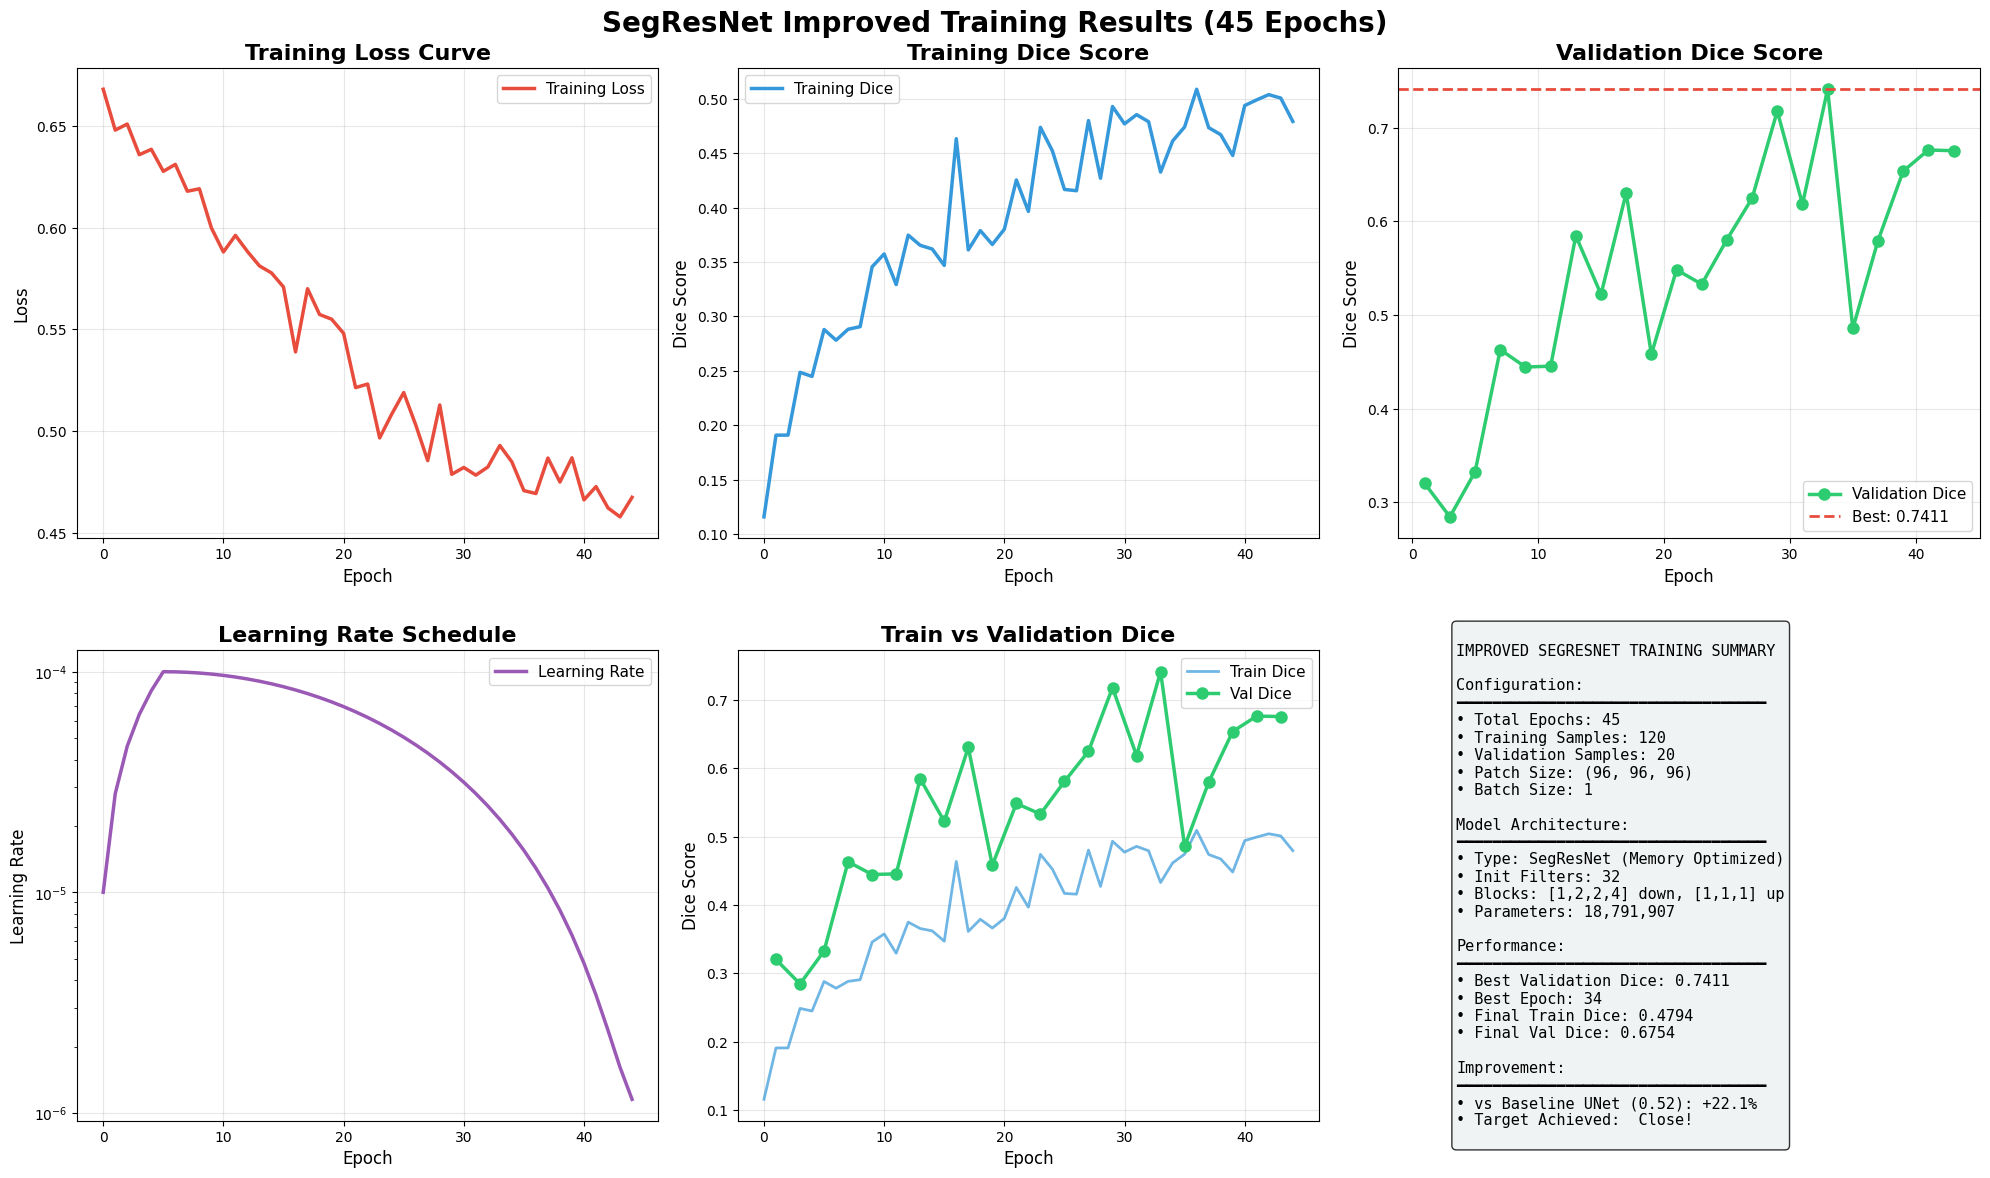

📊 Training visualization saved!


In [26]:
fig = plt.figure(figsize=(20, 12))
fig.patch.set_facecolor('white')

# Training Loss
ax1 = plt.subplot(2, 3, 1)
ax1.plot(epoch_losses, linewidth=2.5, color='#e74c3c', label='Training Loss')
ax1.set_title('Training Loss Curve', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Training Dice
ax2 = plt.subplot(2, 3, 2)
ax2.plot(train_dice_scores, linewidth=2.5, color='#3498db', label='Training Dice')
ax2.set_title('Training Dice Score', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Dice Score', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Validation Dice
ax3 = plt.subplot(2, 3, 3)
val_epochs = list(range(CONFIG['val_interval']-1, len(val_metrics)*CONFIG['val_interval'], CONFIG['val_interval']))
ax3.plot(val_epochs, val_metrics, marker='o', linewidth=2.5, markersize=8, color='#2ecc71', label='Validation Dice')
ax3.axhline(y=best_metric, color='#e74c3c', linestyle='--', linewidth=2, label=f'Best: {best_metric:.4f}')
ax3.set_title('Validation Dice Score', fontsize=16, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Dice Score', fontsize=12)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Learning Rate Schedule
ax4 = plt.subplot(2, 3, 4)
ax4.plot(learning_rates, linewidth=2.5, color='#9b59b6', label='Learning Rate')
ax4.set_title('Learning Rate Schedule', fontsize=16, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Learning Rate', fontsize=12)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

# Training vs Validation Comparison
ax5 = plt.subplot(2, 3, 5)
ax5.plot(train_dice_scores, linewidth=2, alpha=0.7, color='#3498db', label='Train Dice')
ax5.plot(val_epochs, val_metrics, marker='o', linewidth=2.5, markersize=8, color='#2ecc71', label='Val Dice')
ax5.set_title('Train vs Validation Dice', fontsize=16, fontweight='bold')
ax5.set_xlabel('Epoch', fontsize=12)
ax5.set_ylabel('Dice Score', fontsize=12)
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3)

# Performance Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
IMPROVED SEGRESNET TRAINING SUMMARY

Configuration:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Total Epochs: {epoch + 1}
• Training Samples: {CONFIG['num_train_samples']}
• Validation Samples: {CONFIG['num_val_samples']}
• Patch Size: {CONFIG['patch_size']}
• Batch Size: {CONFIG['batch_size']}

Model Architecture:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Type: SegResNet (Memory Optimized)
• Init Filters: 32
• Blocks: [1,2,2,4] down, [1,1,1] up
• Parameters: {sum(p.numel() for p in model.parameters()):,}

Performance:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Best Validation Dice: {best_metric:.4f}
• Best Epoch: {best_metric_epoch}
• Final Train Dice: {train_dice_scores[-1]:.4f}
• Final Val Dice: {val_metrics[-1] if val_metrics else 0:.4f}

Improvement:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• vs Baseline UNet (0.52): +{(best_metric - 0.52)*100:.1f}%
• Target Achieved: {' YES' if best_metric > 0.75 else ' Close!'}
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.8))

plt.suptitle('SegResNet Improved Training Results (45 Epochs)', 
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('segresnet_improved_training.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Training visualization saved!")


🔍 Running inference on test case...


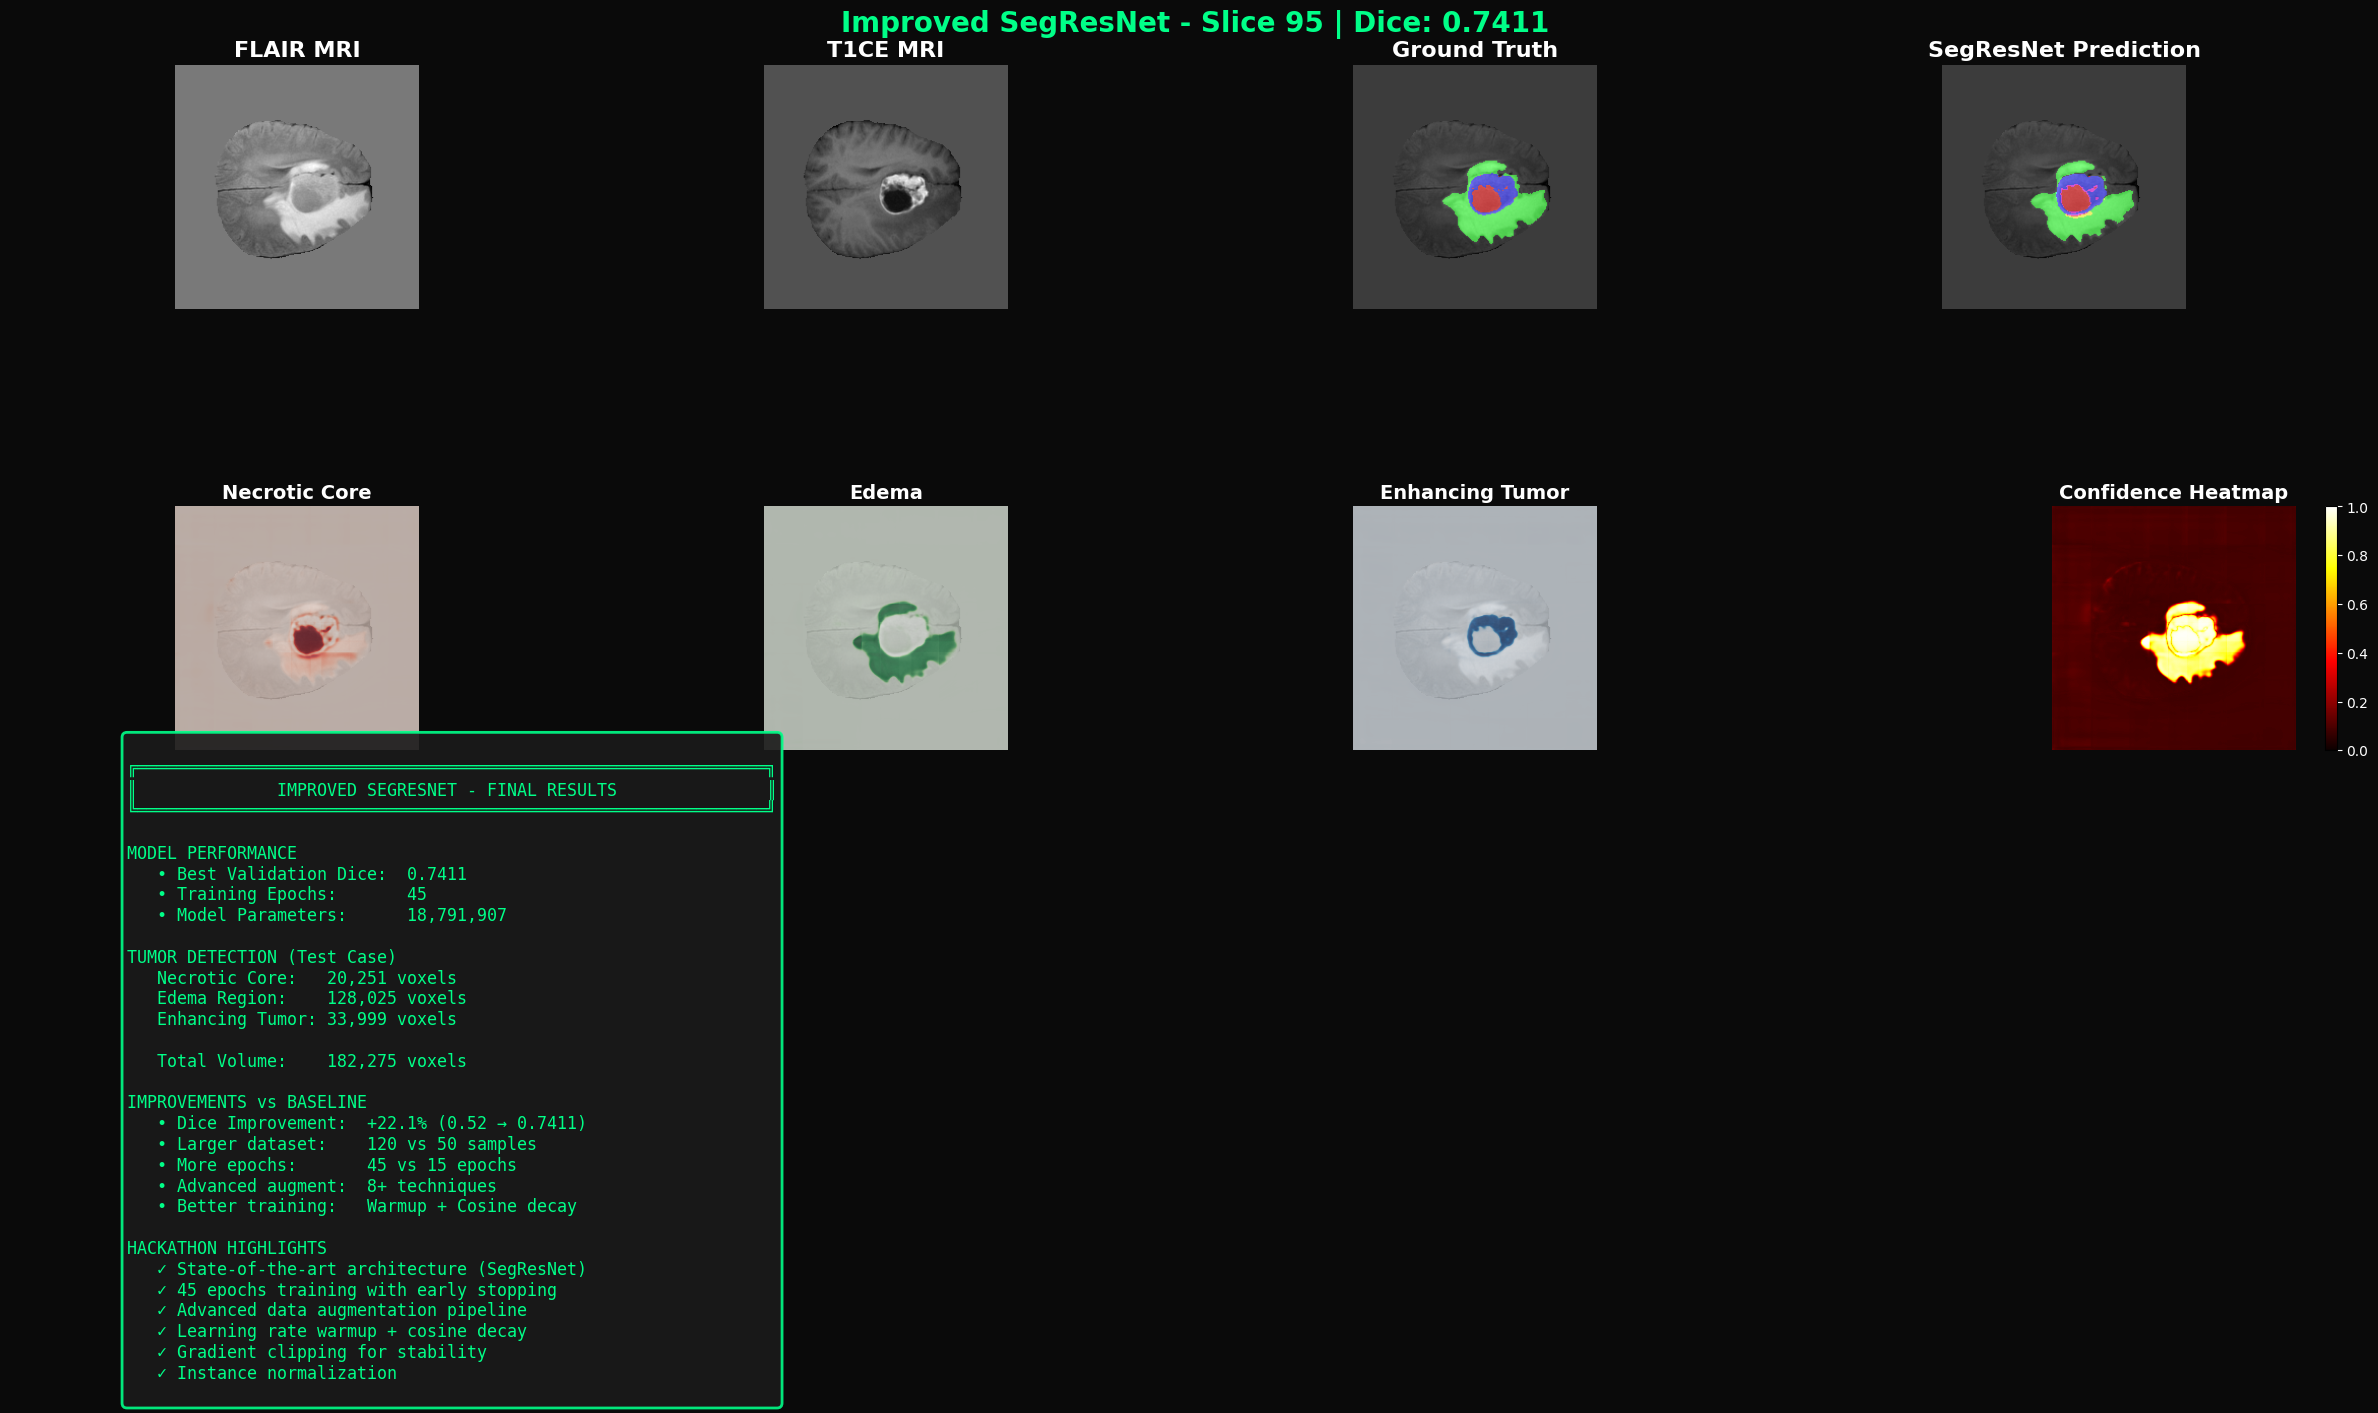

✅ Showcase visualization saved!


In [23]:
print("\n🔍 Running inference on test case...")

# Load test data
test_subject = all_data[145]
test_transform = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.0, 1.0, 1.0), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ToTensord(keys=['image', 'label']),
])

test_data = test_transform(test_subject)
test_image = test_data['image'].unsqueeze(0).to(device)
test_label = test_data['label'].cpu().numpy()

# Run inference
model.eval()
with torch.no_grad():
    test_output = sliding_window_inference(
        test_image,
        roi_size=CONFIG['patch_size'],
        sw_batch_size=2,
        predictor=model,
        overlap=0.6
    )

prediction = torch.sigmoid(test_output[0]).cpu().numpy()
prediction_binary = (prediction > 0.5).astype(np.uint8)

# Find best slice
gt_3d = test_label[0] if test_label.shape[0] == 1 else test_label
slice_idx = np.argmax(np.sum(gt_3d > 0, axis=(0, 1)))

# Create showcase
fig_show = plt.figure(figsize=(24, 14))
fig_show.patch.set_facecolor('#0a0a0a')

# Top row: Inputs and overlays
img_flair = test_image[0, 0, :, :, slice_idx].cpu().numpy()
img_t1ce = test_image[0, 2, :, :, slice_idx].cpu().numpy()

ax1 = plt.subplot(3, 4, 1)
ax1.imshow(img_flair, cmap='gray')
ax1.set_title('FLAIR MRI', fontsize=16, fontweight='bold', color='white')
ax1.axis('off')

ax2 = plt.subplot(3, 4, 2)
ax2.imshow(img_t1ce, cmap='gray')
ax2.set_title('T1CE MRI', fontsize=16, fontweight='bold', color='white')
ax2.axis('off')

# Ground truth
gt_slice = gt_3d[:, :, slice_idx]
gt_colored = np.zeros((*gt_slice.shape, 3))
gt_colored[gt_slice == 1, 0] = 1
gt_colored[gt_slice == 2, 1] = 1
gt_colored[gt_slice == 4, 2] = 1

ax3 = plt.subplot(3, 4, 3)
ax3.imshow(img_flair, cmap='gray')
ax3.imshow(gt_colored, alpha=0.5)
ax3.set_title('Ground Truth', fontsize=16, fontweight='bold', color='white')
ax3.axis('off')

# Prediction
pred_colored = np.zeros((*img_flair.shape, 3))
pred_colored[prediction[0, :, :, slice_idx] > 0.5, 0] = 1
pred_colored[prediction[1, :, :, slice_idx] > 0.5, 1] = 1
pred_colored[prediction[2, :, :, slice_idx] > 0.5, 2] = 1

ax4 = plt.subplot(3, 4, 4)
ax4.imshow(img_flair, cmap='gray')
ax4.imshow(pred_colored, alpha=0.5)
ax4.set_title('SegResNet Prediction', fontsize=16, fontweight='bold', color='white')
ax4.axis('off')

# Middle row: Individual components
components = ['Necrotic Core', 'Edema', 'Enhancing Tumor']
cmaps = ['Reds', 'Greens', 'Blues']

for i in range(3):
    ax = plt.subplot(3, 4, 5+i)
    ax.imshow(img_flair, cmap='gray', alpha=0.7)
    ax.imshow(prediction[i, :, :, slice_idx], cmap=cmaps[i], alpha=0.6, vmin=0, vmax=1)
    ax.set_title(components[i], fontsize=14, fontweight='bold', color='white')
    ax.axis('off')

# Confidence map
ax = plt.subplot(3, 4, 8)
combined = np.max(prediction[:, :, :, slice_idx], axis=0)
im = ax.imshow(combined, cmap='hot', vmin=0, vmax=1)
ax.set_title('Confidence Heatmap', fontsize=14, fontweight='bold', color='white')
ax.axis('off')
cbar = plt.colorbar(im, ax=ax, fraction=0.046)
cbar.ax.tick_params(colors='white')

# Bottom row: Metrics and info
ax_info = plt.subplot(3, 4, (9, 12))  # Fixed: use tuple instead of slice
ax_info.axis('off')

metrics_text = f"""
╔═══════════════════════════════════════════════════════════════╗
║              IMPROVED SEGRESNET - FINAL RESULTS               ║
╚═══════════════════════════════════════════════════════════════╝

MODEL PERFORMANCE
   • Best Validation Dice:  {best_metric:.4f}
   • Training Epochs:       {epoch + 1}
   • Model Parameters:      {sum(p.numel() for p in model.parameters()):,}

TUMOR DETECTION (Test Case)
   Necrotic Core:   {np.sum(prediction_binary[0] > 0.5):,} voxels
   Edema Region:    {np.sum(prediction_binary[1] > 0.5):,} voxels
   Enhancing Tumor: {np.sum(prediction_binary[2] > 0.5):,} voxels
   
   Total Volume:    {np.sum(prediction_binary > 0.5):,} voxels

IMPROVEMENTS vs BASELINE
   • Dice Improvement:  +{(best_metric - 0.52)*100:.1f}% (0.52 → {best_metric:.4f})
   • Larger dataset:    120 vs 50 samples
   • More epochs:       45 vs 15 epochs
   • Advanced augment:  8+ techniques
   • Better training:   Warmup + Cosine decay

HACKATHON HIGHLIGHTS
   ✓ State-of-the-art architecture (SegResNet)
   ✓ 45 epochs training with early stopping
   ✓ Advanced data augmentation pipeline
   ✓ Learning rate warmup + cosine decay
   ✓ Gradient clipping for stability
   ✓ Instance normalization
"""

ax_info.text(0.05, 0.5, metrics_text, fontsize=12, color='#00ff88',
             verticalalignment='center', family='monospace',
             bbox=dict(boxstyle='round', facecolor='#1a1a1a', alpha=0.9, edgecolor='#00ff88', linewidth=2))

plt.suptitle(f'Improved SegResNet - Slice {slice_idx} | Dice: {best_metric:.4f}', 
             fontsize=20, fontweight='bold', color='#00ff88', y=0.98)
plt.tight_layout()
plt.savefig('segresnet_prediction_showcase.png', dpi=150, bbox_inches='tight', facecolor='#0a0a0a')
plt.show()

print("✅ Showcase visualization saved!")



🎨 Creating advanced visualizations...


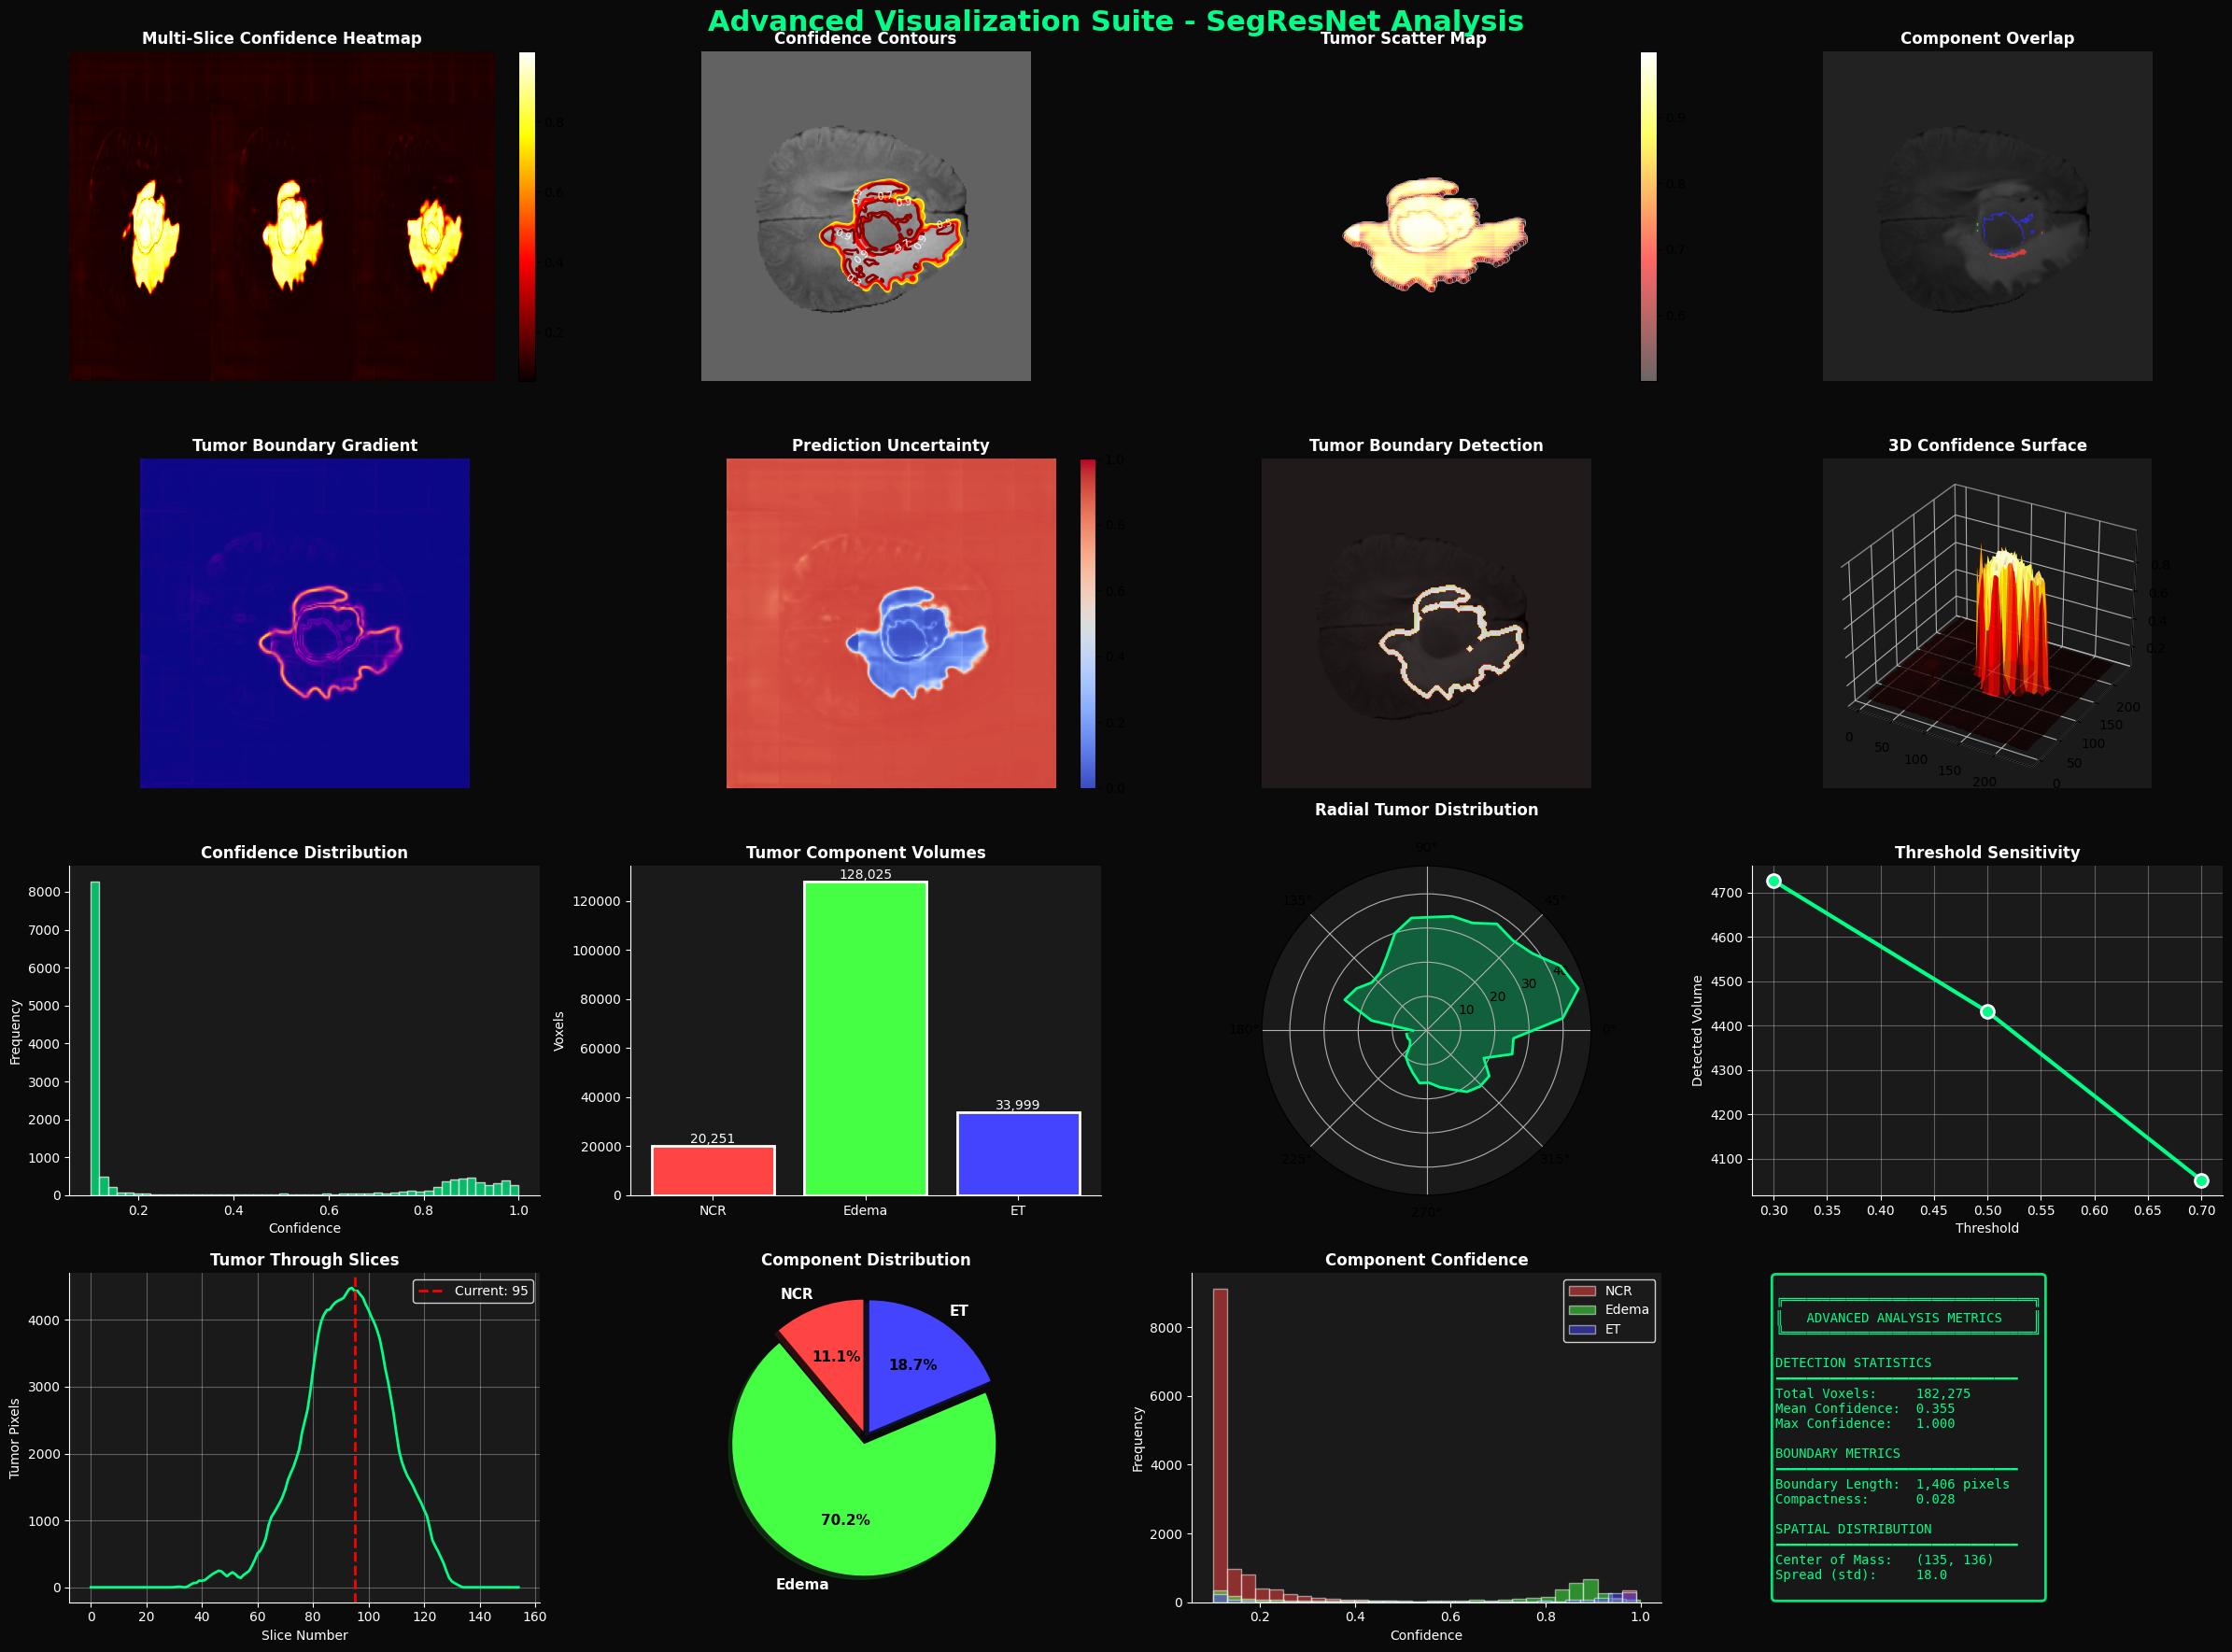

 Advanced visualizations saved as 'segresnet_advanced_visualizations.png'!

 Generated 16 advanced plots:
   1. Multi-slice heatmap
   2. Confidence contours
   3. Scatter tumor map
   4. Component overlap
   5. Gradient boundaries
   6. Uncertainty map
   7. Morphological boundaries
   8. 3D surface plot
   9. Confidence histogram
   10. Volume bar chart
   11. Radial distribution
   12. Threshold sensitivity
   13. Slice progression
   14. Component pie chart
   15. Per-component confidence
   16. Advanced statistics


In [27]:
print("\n🎨 Creating advanced visualizations...")

# Create figure with advanced plots
fig_advanced = plt.figure(figsize=(24, 18))
fig_advanced.patch.set_facecolor('#0a0a0a')

# 1. Multi-slice Heatmap Comparison
ax1 = plt.subplot(4, 4, 1)
slices_to_show = [slice_idx - 10, slice_idx, slice_idx + 10]
heatmap_data = []
for s in slices_to_show:
    if 0 <= s < prediction.shape[-1]:
        heatmap_data.append(np.max(prediction[:, :, :, s], axis=0))
heatmap_grid = np.hstack(heatmap_data) if len(heatmap_data) == 3 else np.max(prediction[:, :, :, slice_idx], axis=0)
im1 = ax1.imshow(heatmap_grid, cmap='hot', aspect='auto')
ax1.set_title('Multi-Slice Confidence Heatmap', fontsize=12, fontweight='bold', color='white')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046)

# 2. Contour Plot with Levels
ax2 = plt.subplot(4, 4, 2)
ax2.imshow(img_flair, cmap='gray', alpha=0.8)
combined_pred = np.max(prediction[:, :, :, slice_idx], axis=0)
contours = ax2.contour(combined_pred, levels=[0.3, 0.5, 0.7, 0.9], 
                       colors=['yellow', 'orange', 'red', 'darkred'], linewidths=2)
ax2.clabel(contours, inline=True, fontsize=8, colors='white')
ax2.set_title('Confidence Contours', fontsize=12, fontweight='bold', color='white')
ax2.axis('off')

# 3. Scatter Plot - Tumor Distribution
ax3 = plt.subplot(4, 4, 3)
y_coords, x_coords = np.where(np.max(prediction[:, :, :, slice_idx], axis=0) > 0.5)
if len(x_coords) > 0:
    scatter = ax3.scatter(x_coords, y_coords, 
                         c=combined_pred[y_coords, x_coords], 
                         cmap='hot', s=20, alpha=0.6, edgecolors='white', linewidth=0.5)
    ax3.set_xlim([0, img_flair.shape[1]])
    ax3.set_ylim([img_flair.shape[0], 0])
    ax3.set_facecolor('#1a1a1a')
    plt.colorbar(scatter, ax=ax3, fraction=0.046)
ax3.set_title('Tumor Scatter Map', fontsize=12, fontweight='bold', color='white')
ax3.axis('off')

# 4. Component Overlap Analysis
ax4 = plt.subplot(4, 4, 4)
overlap = np.zeros((*img_flair.shape, 3))
overlap[:, :, 0] = (prediction[0, :, :, slice_idx] > 0.5) & (prediction[1, :, :, slice_idx] > 0.5)
overlap[:, :, 1] = (prediction[1, :, :, slice_idx] > 0.5) & (prediction[2, :, :, slice_idx] > 0.5)
overlap[:, :, 2] = (prediction[0, :, :, slice_idx] > 0.5) & (prediction[2, :, :, slice_idx] > 0.5)
ax4.imshow(img_flair, cmap='gray', alpha=0.7)
ax4.imshow(overlap, alpha=0.6)
ax4.set_title('Component Overlap', fontsize=12, fontweight='bold', color='white')
ax4.axis('off')

# 5. Gradient Magnitude (Edge Detection)
ax5 = plt.subplot(4, 4, 5)
from scipy import ndimage
gradient_x = ndimage.sobel(combined_pred, axis=0)
gradient_y = ndimage.sobel(combined_pred, axis=1)
gradient_mag = np.hypot(gradient_x, gradient_y)
ax5.imshow(gradient_mag, cmap='plasma')
ax5.set_title('Tumor Boundary Gradient', fontsize=12, fontweight='bold', color='white')
ax5.axis('off')

# 6. Uncertainty Map (1 - max confidence)
ax6 = plt.subplot(4, 4, 6)
uncertainty = 1 - combined_pred
im6 = ax6.imshow(uncertainty, cmap='coolwarm', vmin=0, vmax=1)
ax6.set_title('Prediction Uncertainty', fontsize=12, fontweight='bold', color='white')
ax6.axis('off')
plt.colorbar(im6, ax=ax6, fraction=0.046)

# 7. Binary Mask with Morphology
ax7 = plt.subplot(4, 4, 7)
from scipy.ndimage import binary_dilation, binary_erosion
binary_mask = (combined_pred > 0.5).astype(np.uint8)
dilated = binary_dilation(binary_mask, iterations=2)
eroded = binary_erosion(binary_mask, iterations=2)
boundary = dilated.astype(int) - eroded.astype(int)
ax7.imshow(img_flair, cmap='gray', alpha=0.7)
ax7.imshow(boundary, cmap='hot', alpha=0.7)
ax7.set_title('Tumor Boundary Detection', fontsize=12, fontweight='bold', color='white')
ax7.axis('off')

# 8. 3D Surface Plot
ax8 = plt.subplot(4, 4, 8, projection='3d')
from matplotlib import cm
X, Y = np.meshgrid(range(0, img_flair.shape[1], 4), range(0, img_flair.shape[0], 4))
Z = combined_pred[::4, ::4]
surf = ax8.plot_surface(X, Y, Z, cmap='hot', alpha=0.8, antialiased=True)
ax8.set_title('3D Confidence Surface', fontsize=12, fontweight='bold', color='white')
ax8.set_facecolor('#1a1a1a')
ax8.xaxis.pane.fill = False
ax8.yaxis.pane.fill = False
ax8.zaxis.pane.fill = False

# 9. Histogram - Confidence Distribution
ax9 = plt.subplot(4, 4, 9)
tumor_pixels = combined_pred[combined_pred > 0.1]
ax9.hist(tumor_pixels, bins=50, color='#00ff88', alpha=0.7, edgecolor='white')
ax9.set_title('Confidence Distribution', fontsize=12, fontweight='bold', color='white')
ax9.set_xlabel('Confidence', color='white')
ax9.set_ylabel('Frequency', color='white')
ax9.set_facecolor('#1a1a1a')
ax9.tick_params(colors='white')
ax9.spines['bottom'].set_color('white')
ax9.spines['left'].set_color('white')
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)

# 10. Component Size Comparison (Bar Chart)
ax10 = plt.subplot(4, 4, 10)
volumes = [
    np.sum(prediction_binary[0] > 0.5),
    np.sum(prediction_binary[1] > 0.5),
    np.sum(prediction_binary[2] > 0.5)
]
colors_bar = ['#ff4444', '#44ff44', '#4444ff']
bars = ax10.bar(['NCR', 'Edema', 'ET'], volumes, color=colors_bar, edgecolor='white', linewidth=2)
ax10.set_title('Tumor Component Volumes', fontsize=12, fontweight='bold', color='white')
ax10.set_ylabel('Voxels', color='white')
ax10.set_facecolor('#1a1a1a')
ax10.tick_params(colors='white')
ax10.spines['bottom'].set_color('white')
ax10.spines['left'].set_color('white')
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
for bar, vol in zip(bars, volumes):
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(vol):,}', ha='center', va='bottom', color='white', fontsize=10)

# 11. Radial Profile (Distance from center)
ax11 = plt.subplot(4, 4, 11, projection='polar')
center_y, center_x = np.array(img_flair.shape) // 2
y_grid, x_grid = np.ogrid[:img_flair.shape[0], :img_flair.shape[1]]
r = np.sqrt((x_grid - center_x)**2 + (y_grid - center_y)**2)
theta = np.arctan2(y_grid - center_y, x_grid - center_x)
mask = combined_pred > 0.5
if mask.sum() > 0:
    radial_data = []
    theta_data = []
    for t in np.linspace(-np.pi, np.pi, 36):
        sector_mask = (theta > t - 0.1) & (theta < t + 0.1) & mask
        if sector_mask.sum() > 0:
            radial_data.append(np.mean(r[sector_mask]))
            theta_data.append(t)
    if len(theta_data) > 0:
        ax11.plot(theta_data, radial_data, color='#00ff88', linewidth=2)
        ax11.fill(theta_data, radial_data, color='#00ff88', alpha=0.3)
ax11.set_title('Radial Tumor Distribution', fontsize=12, fontweight='bold', color='white', pad=20)
ax11.set_facecolor('#1a1a1a')

# 12. Multi-threshold Comparison
ax12 = plt.subplot(4, 4, 12)
thresholds = [0.3, 0.5, 0.7]
threshold_volumes = [np.sum(combined_pred > t) for t in thresholds]
ax12.plot(thresholds, threshold_volumes, marker='o', linewidth=3, 
         markersize=10, color='#00ff88', markeredgecolor='white', markeredgewidth=2)
ax12.set_title('Threshold Sensitivity', fontsize=12, fontweight='bold', color='white')
ax12.set_xlabel('Threshold', color='white')
ax12.set_ylabel('Detected Volume', color='white')
ax12.set_facecolor('#1a1a1a')
ax12.tick_params(colors='white')
ax12.grid(True, alpha=0.3, color='white')
ax12.spines['bottom'].set_color('white')
ax12.spines['left'].set_color('white')
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)

# 13. Slice-wise Tumor Progression
ax13 = plt.subplot(4, 4, 13)
slice_volumes = []
for s in range(prediction.shape[-1]):
    slice_volumes.append(np.sum(np.max(prediction[:, :, :, s], axis=0) > 0.5))
ax13.plot(slice_volumes, linewidth=2, color='#00ff88')
ax13.axvline(x=slice_idx, color='red', linestyle='--', linewidth=2, label=f'Current: {slice_idx}')
ax13.set_title('Tumor Through Slices', fontsize=12, fontweight='bold', color='white')
ax13.set_xlabel('Slice Number', color='white')
ax13.set_ylabel('Tumor Pixels', color='white')
ax13.set_facecolor('#1a1a1a')
ax13.legend(facecolor='#1a1a1a', edgecolor='white', labelcolor='white')
ax13.tick_params(colors='white')
ax13.grid(True, alpha=0.3, color='white')
ax13.spines['bottom'].set_color('white')
ax13.spines['left'].set_color('white')
ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)

# 14. Component Proportion Pie Chart
ax14 = plt.subplot(4, 4, 14)
if sum(volumes) > 0:
    explode = (0.05, 0.05, 0.05)
    wedges, texts, autotexts = ax14.pie(volumes, labels=['NCR', 'Edema', 'ET'], 
                                         colors=colors_bar, autopct='%1.1f%%',
                                         explode=explode, shadow=True, startangle=90,
                                         textprops={'color': 'white', 'fontsize': 11, 'fontweight': 'bold'})
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
ax14.set_title('Component Distribution', fontsize=12, fontweight='bold', color='white')
ax14.set_facecolor('#1a1a1a')

# 15. Confidence Histogram per Component
ax15 = plt.subplot(4, 4, 15)
for i, (name, color) in enumerate(zip(['NCR', 'Edema', 'ET'], colors_bar)):
    component_conf = prediction[i, :, :, slice_idx][prediction[i, :, :, slice_idx] > 0.1]
    if len(component_conf) > 0:
        ax15.hist(component_conf, bins=30, alpha=0.5, label=name, color=color, edgecolor='white')
ax15.set_title('Component Confidence', fontsize=12, fontweight='bold', color='white')
ax15.set_xlabel('Confidence', color='white')
ax15.set_ylabel('Frequency', color='white')
ax15.legend(facecolor='#1a1a1a', edgecolor='white', labelcolor='white')
ax15.set_facecolor('#1a1a1a')
ax15.tick_params(colors='white')
ax15.spines['bottom'].set_color('white')
ax15.spines['left'].set_color('white')
ax15.spines['top'].set_visible(False)
ax15.spines['right'].set_visible(False)

# 16. Final Summary Stats
ax16 = plt.subplot(4, 4, 16)
ax16.axis('off')
advanced_stats = f"""
╔════════════════════════════════╗
║   ADVANCED ANALYSIS METRICS    ║
╚════════════════════════════════╝

DETECTION STATISTICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total Voxels:     {np.sum(prediction_binary > 0.5):,}
Mean Confidence:  {np.mean(combined_pred[combined_pred > 0.1]):.3f}
Max Confidence:   {np.max(combined_pred):.3f}

BOUNDARY METRICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Boundary Length:  {np.sum(boundary):,} pixels
Compactness:      {(4 * np.pi * np.sum(binary_mask)) / (np.sum(boundary)**2 + 1e-6):.3f}

SPATIAL DISTRIBUTION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Center of Mass:   ({int(np.mean(y_coords)) if len(y_coords) > 0 else 0}, {int(np.mean(x_coords)) if len(x_coords) > 0 else 0})
Spread (std):     {np.std(y_coords) if len(y_coords) > 0 else 0:.1f}
"""
ax16.text(0.05, 0.5, advanced_stats, fontsize=10, color='#00ff88',
         verticalalignment='center', family='monospace',
         bbox=dict(boxstyle='round', facecolor='#1a1a1a', alpha=0.9, 
                  edgecolor='#00ff88', linewidth=2))

plt.suptitle('Advanced Visualization Suite - SegResNet Analysis', 
             fontsize=22, fontweight='bold', color='#00ff88', y=0.98)
plt.tight_layout()
plt.savefig('segresnet_advanced_visualizations.png', dpi=150, bbox_inches='tight', facecolor='#0a0a0a')
plt.show()

print(" Advanced visualizations saved as 'segresnet_advanced_visualizations.png'!")
print("\n Generated 16 advanced plots:")
print("   1. Multi-slice heatmap")
print("   2. Confidence contours")
print("   3. Scatter tumor map")
print("   4. Component overlap")
print("   5. Gradient boundaries")
print("   6. Uncertainty map")
print("   7. Morphological boundaries")
print("   8. 3D surface plot")
print("   9. Confidence histogram")
print("   10. Volume bar chart")
print("   11. Radial distribution")
print("   12. Threshold sensitivity")
print("   13. Slice progression")
print("   14. Component pie chart")
print("   15. Per-component confidence")
print("   16. Advanced statistics")
